<a href="https://colab.research.google.com/github/Hritani-Dinda/demo-repo/blob/main/ECommerce_Phase2_(1)_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Machine Learning Regression Analysis - Fixed and Modularized for Jupyter Notebook

# Part 1: Import Libraries and Set Up Environment
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:
import pandas as pd
from google.colab import files

print("Loading and preparing data...")
uploaded = files.upload()

# Corrected filename and method
df = pd.read_csv("data_cleaning (3).csv")
if 'Category' in df.columns:
    df.rename(columns={'Category': 'category'}, inplace=True)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nColumns in the dataset:")
print(df.columns.tolist())
print("\nBasic statistics:")
print(df.describe().T)

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])


Loading and preparing data...


Saving data_cleaning (3).csv to data_cleaning (3).csv
Dataset shape: (48060, 8)

Columns in the dataset:
['product_name', 'price', 'discount', 'selling_proposition', 'color-count', 'rank-sub', 'category', 'category_encoded']

Basic statistics:
                       count        mean          std         min         25%  \
price                48060.0    7.714067     9.731372    0.150000    2.300000   
discount             48060.0    0.147949     0.169427    0.000000    0.000000   
selling_proposition  48060.0  962.730619  1679.946219   10.000000  100.000000   
color-count          48060.0    2.684976     3.858470    1.000000    1.000000   
category_encoded     48060.0  962.730619   677.545632  173.345379  345.787634   

                            50%          75%           max  
price                  5.170000    10.080000    111.640000  
discount               0.080000     0.230000      0.920000  
selling_proposition  300.000000  1000.000000  10000.000000  
color-count            1.

                        price  discount  selling_proposition  color-count  \
price                1.000000  0.026361            -0.048421     0.065015   
discount             0.026361  1.000000            -0.101926     0.060423   
selling_proposition -0.048421 -0.101926             1.000000     0.240432   
color-count          0.065015  0.060423             0.240432     1.000000   
category_encoded     0.040225 -0.052504             0.403314     0.172953   

                     category_encoded  
price                        0.040225  
discount                    -0.052504  
selling_proposition          0.403314  
color-count                  0.172953  
category_encoded             1.000000  


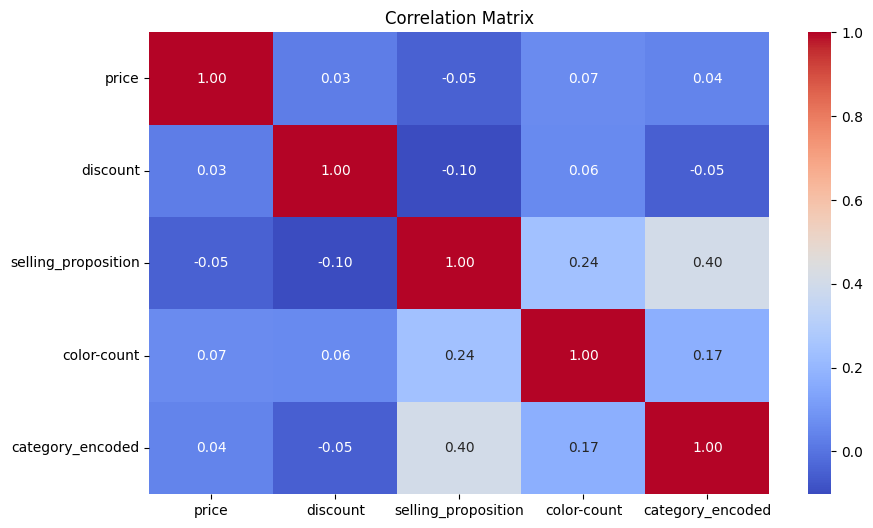

In [4]:
numeric_cols = ['price', 'discount', 'selling_proposition', 'color-count', 'category_encoded']
corr_matrix = df[numeric_cols].corr()

# Display correlation matrix
print(corr_matrix)

# Optional: Visualize with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix reveals key relationships among the variables, particularly the moderate positive correlation between `selling_proposition` and both `category_encoded` (0.40) and `color-count` (0.24), suggesting that category and color variety influence perceived value or positioning. Meanwhile `price` and `discount` exhibit weak correlations with other features, indicating the need for derived metrics to uncover latent patterns. Based on this, the feature engineering process strategically enhanced predictive power by constructing ratio-based features like `discount_ratio` and `price_category_ratio`, which normalize values and highlight relative positioning within categories. Rank-based encodings, smoothed target encodings, and transformations (e.g., log, inverse, polynomial) captured non-linear patterns and frequency effects. Additional features such as `selling_prop_per_dollar` and `color_category_ratio` leveraged observed correlations while accounting for variance across categories. This comprehensive engineering aims to amplify signal strength for downstream modeling, grounded in the initial correlation insights.


In [11]:
def preprocess_data(df):
    """Handle missing values and outliers"""
    # Handle missing values in a more targeted way
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            # Fill numeric columns with median (more robust to outliers)
            df[col] = df[col].fillna(df[col].median())
        else:
            # Fill categorical columns with mode
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")
    df["rank-sub"] = pd.factorize(df["rank-sub"])[0]

    # Apply winsorization to numeric columns instead of removing outliers
    numeric_cols = ['price', 'discount', 'selling_proposition', 'rank-sub']
    for col in numeric_cols:
        if col in df.columns and df[col].dtype in ['int64', 'float64']:
            df = winsorize_outliers(df, col, lower_quantile=0.005, upper_quantile=0.995)

    return df

def winsorize_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    """Winsorize outliers (cap at percentiles) instead of removing them"""
    if column in df.columns and df[column].dtype in ['int64', 'float64']:
        lower_bound = df[column].quantile(lower_quantile)
        upper_bound = df[column].quantile(upper_quantile)
        outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        print(f"Winsorizing {outliers_count} outliers in {column}")
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

df = preprocess_data(df)

Winsorizing 241 outliers in price
Winsorizing 0 outliers in discount
Winsorizing 0 outliers in selling_proposition
Winsorizing 0 outliers in rank-sub


In [12]:
# Count the number of duplicate product names
duplicate_count = df['product_name'].duplicated().sum()
print(f"Number of duplicate product names: {duplicate_count}")

Number of duplicate product names: 0


In [13]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48060 entries, 0 to 48059
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_name         48060 non-null  object 
 1   price                48060 non-null  float64
 2   discount             48060 non-null  float64
 3   selling_proposition  48060 non-null  float64
 4   color-count          48060 non-null  float64
 5   rank-sub             48060 non-null  int64  
 6   category             48060 non-null  object 
 7   category_encoded     48060 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.9+ MB


product_name  price  discount  \
0  " Bathroom Mat, Cute Anti-slip Ultra-fine Fibe...  11.60      0.00   
1  "1 Pair Festive Wooden Earrings With ""Happy G...   0.77      0.52   
2  "24pcs Super Long Coffin-Shaped Nail Tips Deco...   3.20      0.09   
3  "6 Pieces/Set Of Unframed Canvas Posters,  Art...   4.30      0.00   
4  "Extra-Large Microfiber Beach Towel With Adora...   6.83      0.25   

   selling_proposition  color-count  rank-sub           category  \
0                500.0          1.0         0       Home Textile   
1                100.0          1.0         1               Kids   
2                400.0         27.0         2  Beauty And Health   
3                600.0          1.0         3   Home And Kitchen   
4                 50.0          1.0         0       Home Textile   

   category_encoded  
0        219.337553  
1       1056.244473  
2       1692.008790  
3        795.201741  
4        219.337553

Training Models before any Feature Engineering


In [14]:
# Train-Test Split
X = df.drop(columns=['selling_proposition', 'product_name', 'category'])  # Drop the target column ('price')
y = df['selling_proposition']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Display the split shape
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (38448, 5)
Testing data shape: (9612, 5)


Linear Regression Model Performance:
Train R²: 0.2106, Train RMSE: 1487.3549, Train MAE: 869.7277
Test R²: 0.1976, Test RMSE: 1525.5071, Test MAE: 893.2106
Cross-Validation (R²) Scores: [0.21482558 0.22684992 0.21229213 0.20646705 0.19063442]
Mean CV R² Score: 0.2102


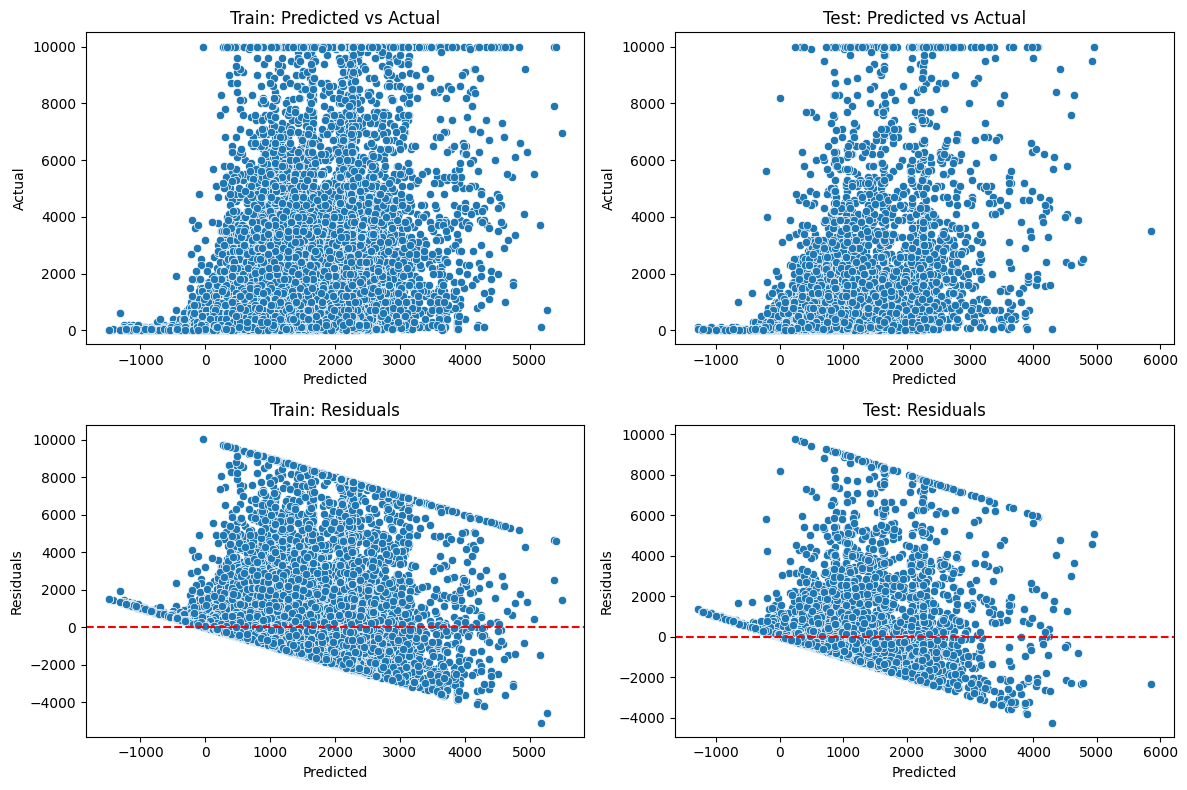

In [16]:
# 1. Train Linear Regression Model with Cross Validation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Training and Testing Performance
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Cross-validation score (R²)
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='r2')

print("Linear Regression Model Performance:")
print(f"Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
print(f"Cross-Validation (R²) Scores: {cv_scores}")
print(f"Mean CV R² Score: {cv_scores.mean():.4f}")

# Visualizing Overfitting/Underfitting
plt.figure(figsize=(12, 8))

# Predicted vs Actual (Training Data)
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_train_pred, y=y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train: Predicted vs Actual')

# Predicted vs Actual (Testing Data)
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test_pred, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test: Predicted vs Actual')

# Residual Plot (Training Data)
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_train_pred, y=y_train - y_train_pred)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Train: Residuals')

# Residual Plot (Testing Data)
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test_pred, y=y_test - y_test_pred)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Test: Residuals')

plt.tight_layout()
plt.show()


The analysis of the Linear Regression model performance indicates that the model is underfitting the data, as reflected by the low R² values for both training (0.2106) and testing (0.1976) sets, meaning the model explains only around 21% of the variance in the target variable. The RMSE (1487.35 for training and 1525.51 for testing) and MAE (869.73 for training and 893.21 for testing) highlight significant prediction errors, while the similarity between train and test errors suggests the absence of overfitting but points to the model's simplicity failing to capture the data's complexity. The cross-validation R² scores (mean: 0.2102) further confirm the model's consistent underperformance across different data splits. From the graphs, the "Predicted vs Actual" plots reveal a poor alignment between predictions and actual values, with a wide spread indicating weak predictive accuracy. The residual plots show systematic patterns and non-random distributions, suggesting that the model fails to account for non-linear relationships in the data.

Ridge Regression Model Performance:
Train R²: 0.2106, Test R²: 0.1976
Train RMSE: 1487.3549, Test RMSE: 1525.5062
Train MAE: 869.7092, Test MAE: 893.1923
Cross-Validation (R²) Scores: [0.21482653 0.22684945 0.21229135 0.20646521 0.19063675]
Mean CV R² Score: 0.2102


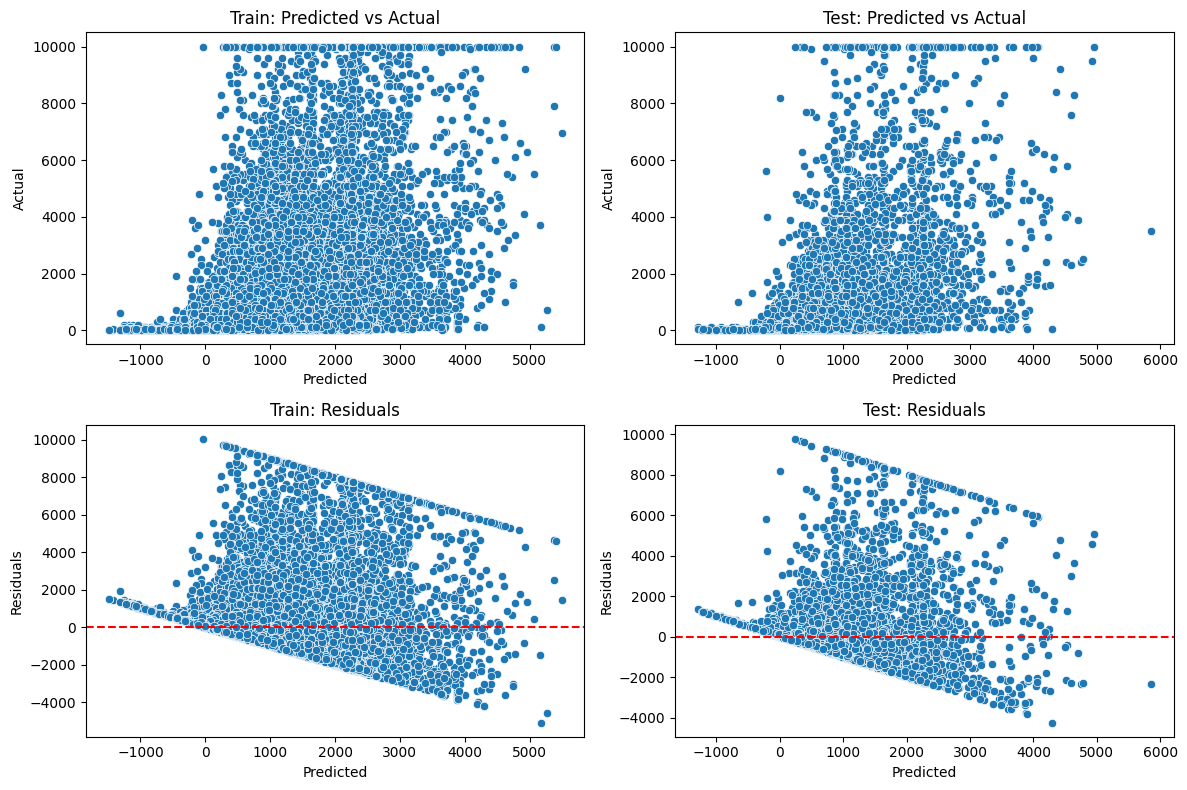

In [21]:
# 2. Train Ridge Regression Model with Cross Validation

from sklearn.linear_model import Ridge

# Initialize and train the model
ridge_model = Ridge(alpha=1.0)  # You can adjust alpha for regularization
ridge_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

# Training and Testing Performance
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)) # Changed y_train_pred_ridge to y_test_pred_ridge
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)

# Cross-validation score (R²)
cv_scores_ridge = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')

print("Ridge Regression Model Performance:")
print(f"Train R²: {train_r2_ridge:.4f}, Test R²: {test_r2_ridge:.4f}")
print(f"Train RMSE: {train_rmse_ridge:.4f}, Test RMSE: {test_rmse_ridge:.4f}")
print(f"Train MAE: {train_mae_ridge:.4f}, Test MAE: {test_mae_ridge:.4f}")
print(f"Cross-Validation (R²) Scores: {cv_scores_ridge}")
print(f"Mean CV R² Score: {cv_scores_ridge.mean():.4f}")

# Visualizing Overfitting/Underfitting
plt.figure(figsize=(12, 8))

# Predicted vs Actual (Training Data)
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_train_pred_ridge, y=y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train: Predicted vs Actual')

# Predicted vs Actual (Testing Data)
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test_pred_ridge, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test: Predicted vs Actual')

# Residual Plot (Training Data)
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_train_pred_ridge, y=y_train - y_train_pred_ridge)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Train: Residuals')

# Residual Plot (Testing Data)
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test_pred_ridge, y=y_test - y_test_pred_ridge)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Test: Residuals')

plt.tight_layout()
plt.show()


The performance of the Ridge Regression model is nearly identical to that of the Linear Regression model, indicating consistent underfitting. The R² values for training (0.2106) and testing (0.1976) sets show that the model explains only about 21% of the variance in the target variable, which is very low and suggests poor predictive ability. The RMSE (1487.35 for training and 1525.51 for testing) and MAE (869.71 for training and 893.19 for testing) confirm significant prediction errors. The similarity between train and test errors, as well as cross-validation R² scores (mean: 0.2102), indicates that the model generalizes consistently but lacks the capacity to model the complexity of the data. The "Predicted vs Actual" plots reveal widespread points, demonstrating weak alignment between predictions and actual values, and residual plots show systematic patterns, emphasizing the model's inability to capture non-linear relationships in the data.

Random Forest Model Performance:
Train R²: 0.6838, Test R²: 0.1926
Train RMSE: 941.4289, Test RMSE: 1530.2578
Train MAE: 485.4384, Test MAE: 853.4232
Cross-Validation (R²) Scores: [0.19113471 0.19514747 0.19096229 0.19194973 0.15289558]
Mean CV R² Score: 0.1844


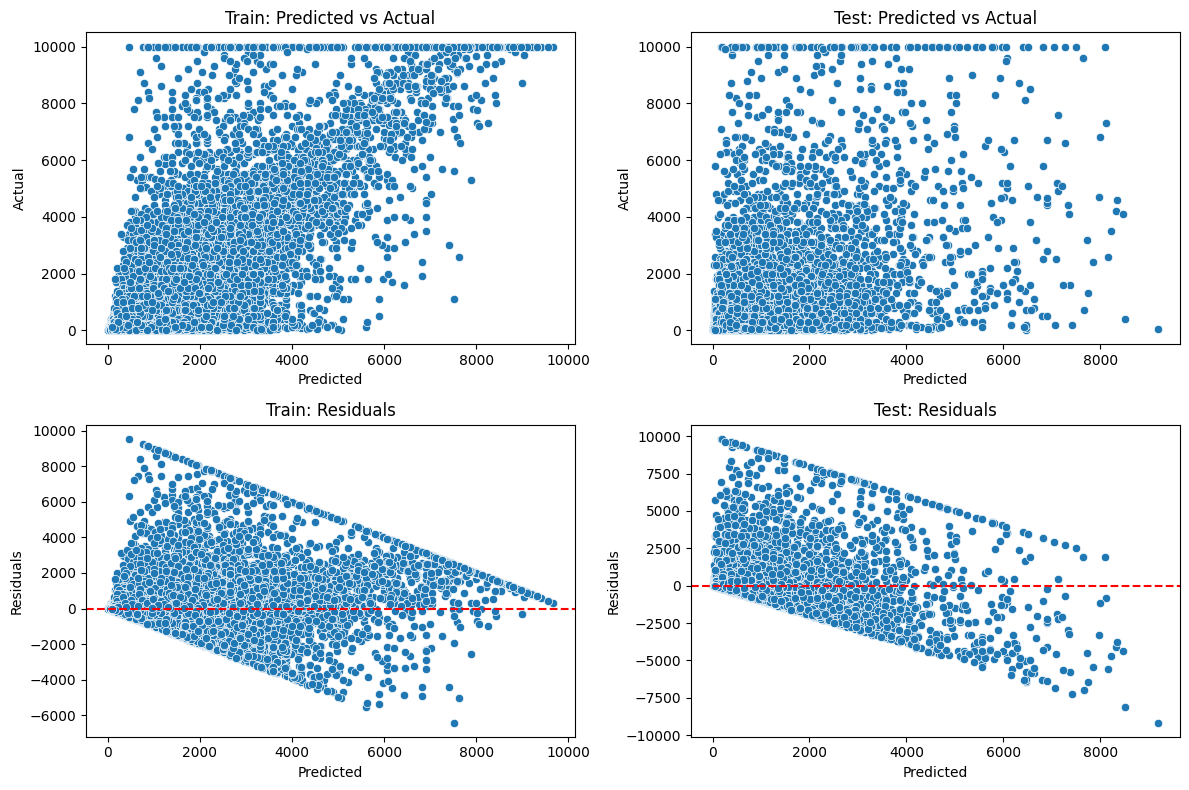

In [22]:
# 3. Train Random Forest Regressor Model with Cross Validation

from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Training and Testing Performance
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)

# Cross-validation score (R²)
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

print("Random Forest Model Performance:")
print(f"Train R²: {train_r2_rf:.4f}, Test R²: {test_r2_rf:.4f}")
print(f"Train RMSE: {train_rmse_rf:.4f}, Test RMSE: {test_rmse_rf:.4f}")
print(f"Train MAE: {train_mae_rf:.4f}, Test MAE: {test_mae_rf:.4f}")
print(f"Cross-Validation (R²) Scores: {cv_scores_rf}")
print(f"Mean CV R² Score: {cv_scores_rf.mean():.4f}")

# Visualizing Overfitting/Underfitting
plt.figure(figsize=(12, 8))

# Predicted vs Actual (Training Data)
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_train_pred_rf, y=y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train: Predicted vs Actual')

# Predicted vs Actual (Testing Data)
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test_pred_rf, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test: Predicted vs Actual')

# Residual Plot (Training Data)
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_train_pred_rf, y=y_train - y_train_pred_rf)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Train: Residuals')

# Residual Plot (Testing Data)
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test_pred_rf, y=y_test - y_test_pred_rf)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Test: Residuals')

plt.tight_layout()
plt.show()


The Random Forest model exhibits significant overfitting, as indicated by the large gap between the Train R² (0.6838) and Test R² (0.1926) values. While the model performs well on the training set, explaining 68.38% of the variance, it fails to generalize to the test set, explaining only 19.26% of the variance. This overfitting is further reflected in the error metrics, with the Train RMSE (941.43) and Train MAE (485.44) being substantially lower than the Test RMSE (1530.26) and Test MAE (853.42). The cross-validation R² scores (mean: 0.1844) are also consistent with the poor generalization, confirming that the model's performance deteriorates across different data splits. The "Predicted vs Actual" plots show a better alignment for the training set compared to the test set, where predictions are more scattered. The residual plots reveal a systematic pattern for both train and test sets, along with heteroscedasticity (increasing spread of residuals with larger predicted values), further highlighting the model's inability to effectively generalize and predict well on unseen data.

XGBoost Model Performance:
Train R²: 0.4343, Test R²: 0.2726
Train RMSE: 1259.0835, Test RMSE: 1452.4209
Train MAE: 712.9441, Test MAE: 813.6431
Cross-Validation (R²) Scores: [0.27802211 0.27421752 0.26799884 0.25992373 0.23645865]
Mean CV R² Score: 0.2633


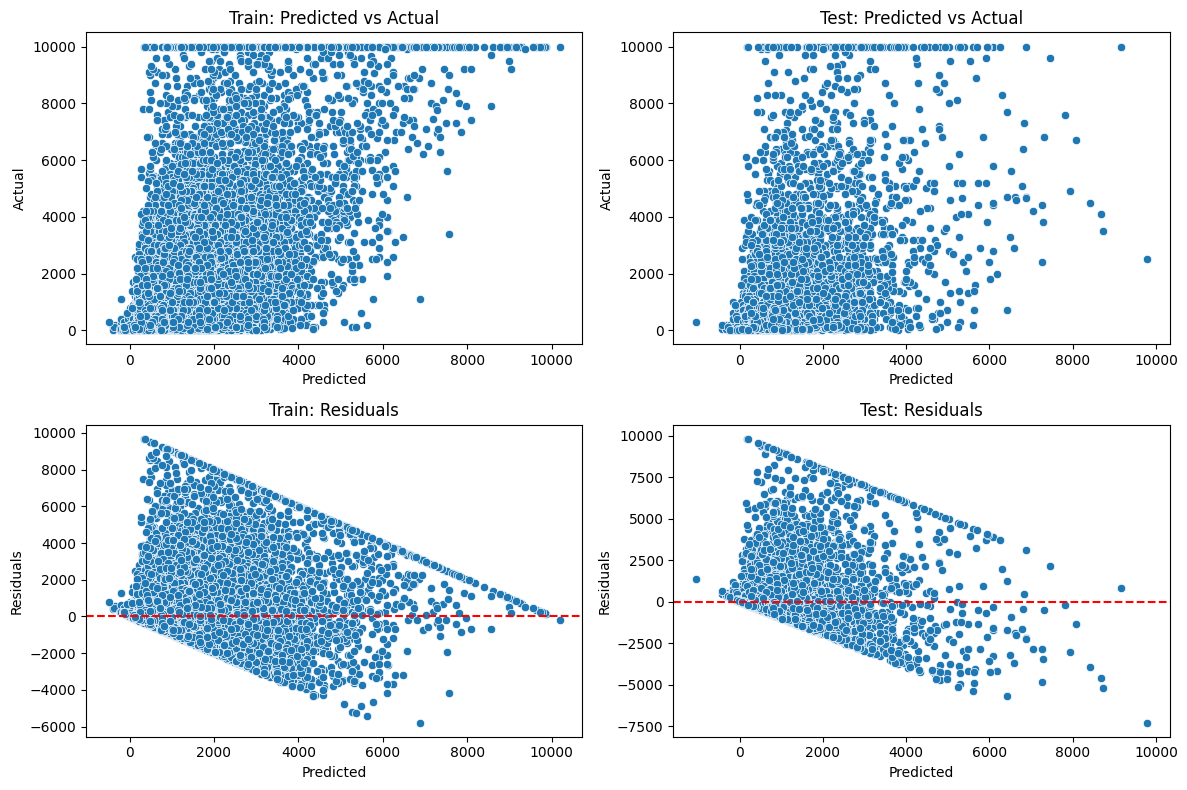

In [23]:
# 4. Train XGBoost Model with Cross Validation

import xgboost as xgb

# Initialize and train the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)
xgb_model.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Training and Testing Performance
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

# Cross-validation score (R²)
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

print("XGBoost Model Performance:")
print(f"Train R²: {train_r2_xgb:.4f}, Test R²: {test_r2_xgb:.4f}")
print(f"Train RMSE: {train_rmse_xgb:.4f}, Test RMSE: {test_rmse_xgb:.4f}")
print(f"Train MAE: {train_mae_xgb:.4f}, Test MAE: {test_mae_xgb:.4f}")
print(f"Cross-Validation (R²) Scores: {cv_scores_xgb}")
print(f"Mean CV R² Score: {cv_scores_xgb.mean():.4f}")

# Visualizing Overfitting/Underfitting
plt.figure(figsize=(12, 8))

# Predicted vs Actual (Training Data)
plt.subplot(2, 2, 1)
sns.scatterplot(x=y_train_pred_xgb, y=y_train)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Train: Predicted vs Actual')

# Predicted vs Actual (Testing Data)
plt.subplot(2, 2, 2)
sns.scatterplot(x=y_test_pred_xgb, y=y_test)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test: Predicted vs Actual')

# Residual Plot (Training Data)
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_train_pred_xgb, y=y_train - y_train_pred_xgb)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Train: Residuals')

# Residual Plot (Testing Data)
plt.subplot(2, 2, 4)
sns.scatterplot(x=y_test_pred_xgb, y=y_test - y_test_pred_xgb)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Test: Residuals')

plt.tight_layout()
plt.show()


The XGBoost model demonstrates moderate performance, with a Train R² of 0.4343 and a Test R² of 0.2726, indicating that the model explains 43.43% of the variance in the training set but only 27.26% in the test set. This suggests some overfitting, as the model performs better on the training data than on unseen test data. The error metrics further support this observation, with Train RMSE (1259.08) and Train MAE (712.94) being lower than Test RMSE (1452.42) and Test MAE (813.64). The cross-validation results, with a mean R² score of 0.2633, confirm the model's consistent performance across different data splits, though the generalization remains suboptimal. The "Predicted vs Actual" plots show better alignment in the training set than in the test set, with the test predictions showing more scatter. The residual plots reveal systematic patterns and heteroscedasticity, as residuals increase in variance with larger predicted values. While XGBoost captures more complexity in the data compared to simpler models, its moderate overfitting and inability to fully generalize indicate the need for further optimization, such as tuning hyperparameters or incorporating additional feature engineering.

Feature Engineering

In [24]:
# Part 4: Feature Engineering
def engineer_features(df):
    """Create new features to improve model performance"""
    print("\nPerforming feature engineering...")

    # Text-based features (if product_name is available)
    if 'product_name' in df.columns:
        # Extract length of product name as a feature
        df['name_length'] = df['product_name'].str.len()
        # Count words in product name
        df['word_count'] = df['product_name'].str.split().str.len()

    # Numeric transformations and ratios
    df['discount_ratio'] = df['discount'] / (df['price'] + 0.001)  # Avoid division by zero
    df['discount_ratio'] = df['discount_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

    # More informative discount features
    df['discount_percentage'] = (df['discount'] / (df['price'] + 0.001)) * 100
    df['discount_percentage'] = df['discount_percentage'].clip(0, 100)
    df['has_discount'] = (df['discount'] > 0).astype(int)

    # Price relative to category
    if 'category_encoded' in df.columns:
        df['price_category_ratio'] = df['price'] / (df.groupby('category_encoded')['price'].transform('mean') + 0.001)
        df['price_category_ratio'] = df['price_category_ratio'].replace([np.inf, -np.inf], 1).fillna(1)

        # Price statistics within category
        df['price_category_pct'] = df.groupby('category_encoded')['price'].transform(
            lambda x: pd.qcut(x.rank(method='first'), q=10, labels=False, duplicates='drop'))
        df['price_zscore'] = df.groupby('category_encoded')['price'].transform(lambda x: (x - x.mean()) / (x.std() + 0.001))

    # Rank-based features
    if 'rank-sub' in df.columns:
        # Create frequency encoding
        category_freq = df['rank-sub'].value_counts(normalize=True)
        df['rank_freq'] = df['rank-sub'].map(category_freq)

        # Create smoothed target encoding
        target_mean = df['selling_proposition'].mean()
        smoothing_factor = 50  # Controls regularization strength

        # Calculate target means per category
        category_target_mean = df.groupby('rank-sub')['selling_proposition'].mean()

        # Calculate counts per category
        category_counts = df['rank-sub'].value_counts()

        # Apply smoothing formula
        df['rank_target_enc'] = df['rank-sub'].map(
            lambda x: (category_target_mean.get(x, target_mean) * category_counts.get(x, 0) + target_mean * smoothing_factor) /
                    (category_counts.get(x, 0) + smoothing_factor)
        )

        # Handle potential NaN for unseen categories (if any)
        df['rank_target_enc'] = df['rank_target_enc'].fillna(target_mean)

        # Log transform of rank (ranks are typically more meaningful on a log scale)
        # Ensure 'rank-sub' is numeric before applying log1p
        df['rank-sub'] = pd.to_numeric(df['rank-sub'], errors='coerce')

        df['log_rank'] = np.log1p(df['rank-sub'])
        df['rank_inverse'] = 1 / (df['rank-sub'] + 1)

        # Fill any resulting NaNs (due to coercion) with defaults
        df['log_rank'] = df['log_rank'].fillna(0)
        df['rank_inverse'] = df['rank_inverse'].replace([np.inf, -np.inf], 0).fillna(0)

        df['rank_inverse'] = 1 / (df['rank-sub'] + 1)  # Add 1 to avoid division by zero

        if 'category_encoded' in df.columns:
            df['rank_norm'] = df['rank-sub'] / (df.groupby('category_encoded')['rank-sub'].transform('max') + 1)
            df['rank_norm'] = df['rank_norm'].fillna(0.5)  # Fill NaN with middle value

            # Rank percentiles within category (more robust)
            df['rank_percentile'] = df.groupby('category_encoded')['rank-sub'].transform(
                lambda x: pd.qcut(x.rank(method='first'), q=10, labels=False, duplicates='drop'))
            df['rank_percentile'] = df['rank_percentile'].fillna(5)

    # Color count interactions
    if 'color-count' in df.columns:
        df['price_per_color'] = df['price'] / (df['color-count'] + 0.001)
        df['price_per_color'] = df['price_per_color'].replace([np.inf, -np.inf], df['price'].mean()).fillna(df['price'].mean())

        if 'category_encoded' in df.columns:
            df['color_category_ratio'] = df['color-count'] / (df.groupby('category_encoded')['color-count'].transform('mean') + 0.001)
            df['color_category_ratio'] = df['color_category_ratio'].replace([np.inf, -np.inf], 1).fillna(1)

            # Categorical interaction terms
            df['category_color_interaction'] = df['category_encoded'] * df['color-count']

    # Polynomial features for important variables
    df['price_squared'] = df['price'] ** 2
    df['discount_squared'] = df['discount'] ** 2
    df['price_discount_interaction'] = df['price'] * df['discount']

    # More selling proposition features
    df['selling_prop_per_dollar'] = df['selling_proposition'] / (df['price'] + 0.001)
    df['selling_prop_per_dollar'] = df['selling_prop_per_dollar'].replace([np.inf, -np.inf], 0).fillna(0)

    # Group statistics for selling proposition
    if 'category_encoded' in df.columns:
        df['selling_prop_category_ratio'] = df['selling_proposition'] / (df.groupby('category_encoded')['selling_proposition'].transform('mean') + 0.001)
        df['selling_prop_category_ratio'] = df['selling_prop_category_ratio'].replace([np.inf, -np.inf], 1).fillna(1)

    return df

df = engineer_features(df)


Performing feature engineering...


In [33]:
original_features = {
    'product_name', 'price', 'discount', 'category',
    'selling_proposition', 'rank-sub', 'color-count',
    'category_encoded'  # Add any other original columns here
}
new_features = list(set(df.columns) - original_features)
print("New features added during feature engineering:", new_features)

print("Summary statistics for new features:")
print(df[new_features].describe().T)


New features added during feature engineering: ['price_category_ratio', 'selling_prop_per_dollar', 'rank_target_enc', 'log_rank', 'price_category_pct', 'price_squared', 'color_category_ratio', 'discount_squared', 'rank_norm', 'rank_inverse', 'name_length', 'price_per_color', 'price_zscore', 'price_discount_interaction', 'discount_ratio', 'category_color_interaction', 'rank_freq', 'discount_percentage', 'has_discount', 'rank_percentile', 'word_count', 'selling_prop_category_ratio']
Summary statistics for new features:
                               count          mean          std         min  \
price_category_ratio         48060.0  9.998359e-01     1.180253    0.040990   
selling_prop_per_dollar      48060.0  2.815964e+02   695.515027    0.133138   
rank_target_enc              48060.0  9.608655e+02   654.709293  190.263194   
log_rank                     48060.0  2.043399e+00     0.799572    0.000000   
price_category_pct           48060.0  4.499584e+00     2.873195    0.000000   
pri

In [28]:
# import os
# import joblib

# def load_or_train(path, train_fn, overwrite=False):
#     """
#     If path exists (and overwrite=False), load and return it.
#     Otherwise, call train_fn() to fit a new model, save it to path, and return it.
#     """
#     if os.path.exists(path) and not overwrite:
#         print(f"Loading model from {path}")
#         return joblib.load(path)
#     else:
#         print(f"Training new model and saving to {path}")
#         model = train_fn()
#         joblib.dump(model, path)
#         # return model

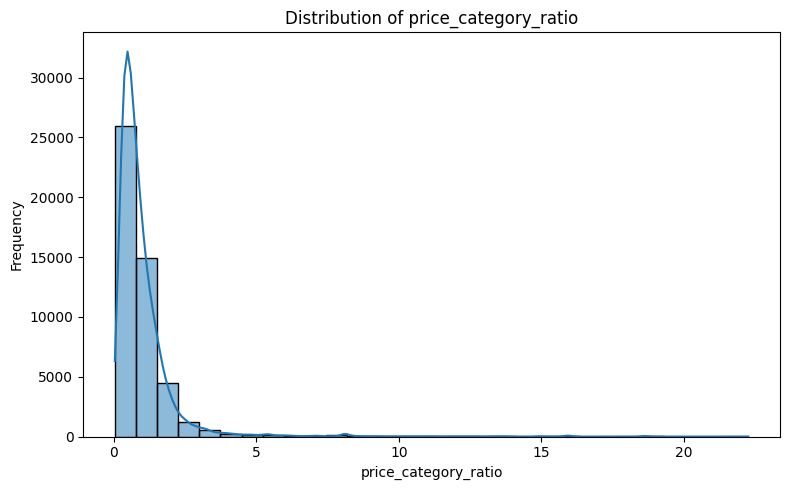

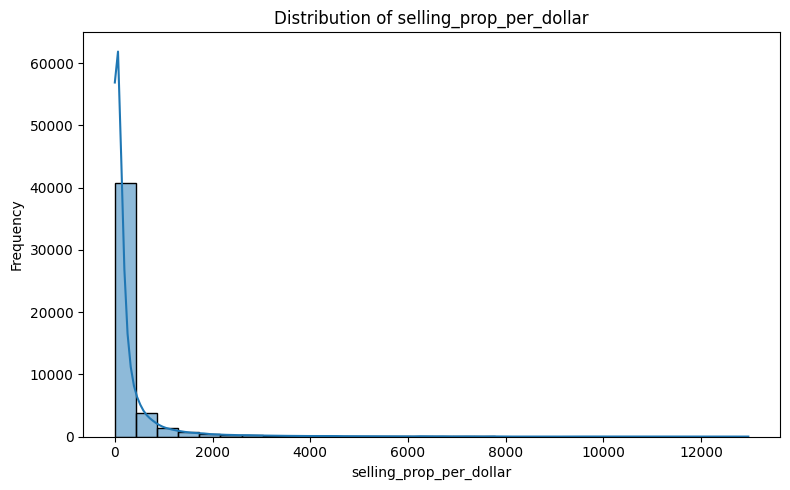

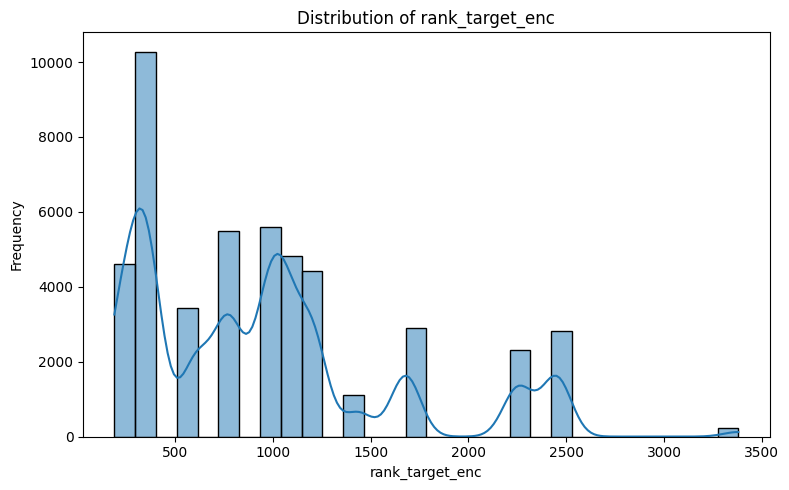

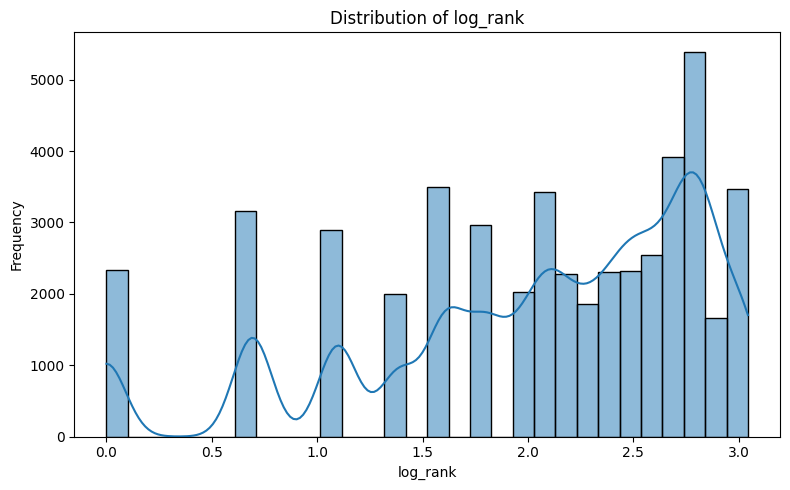

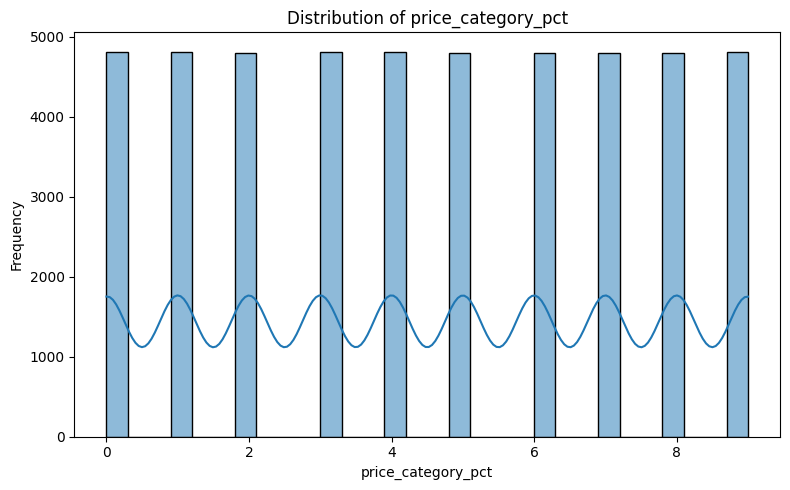

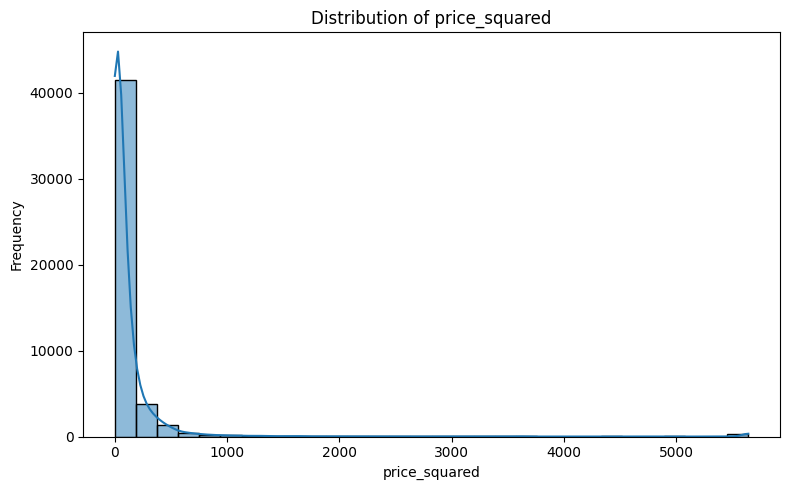

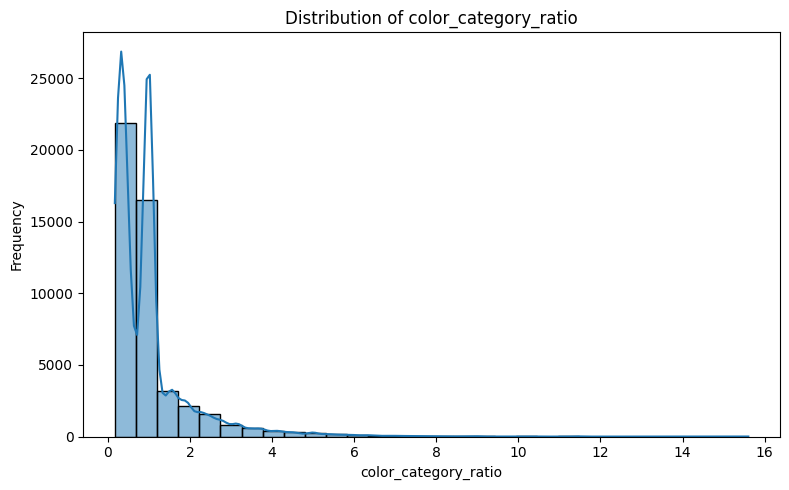

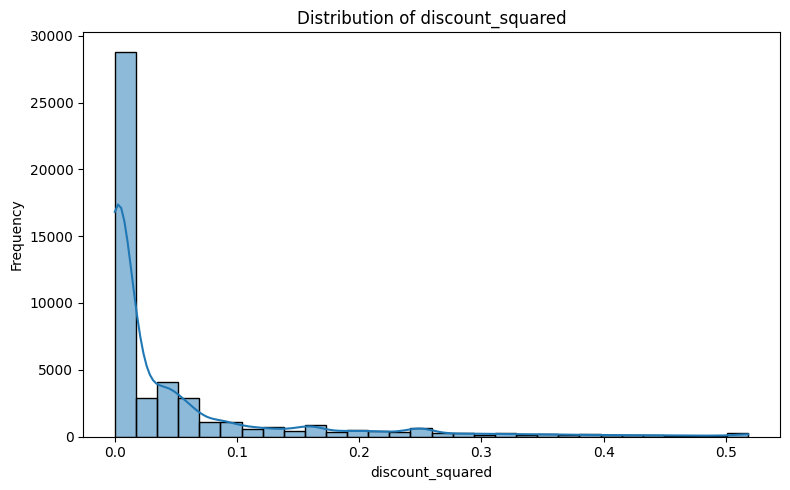

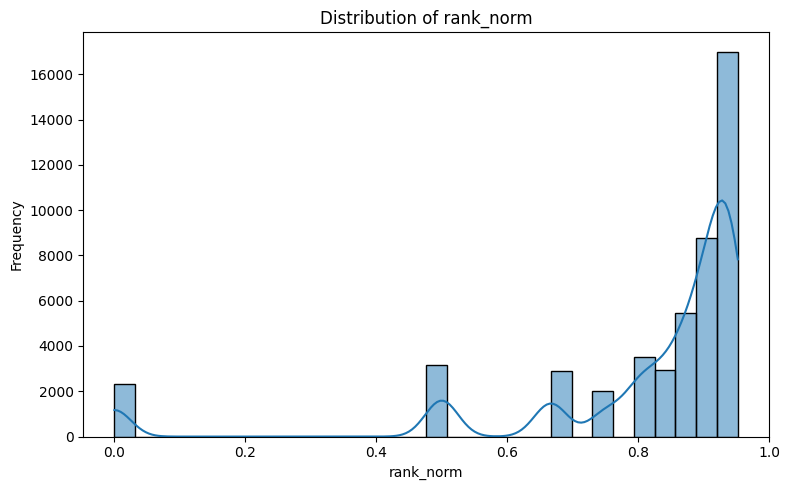

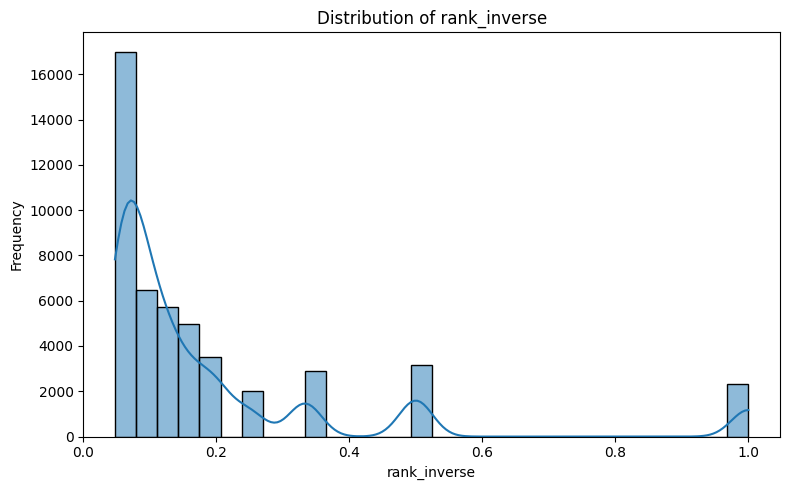

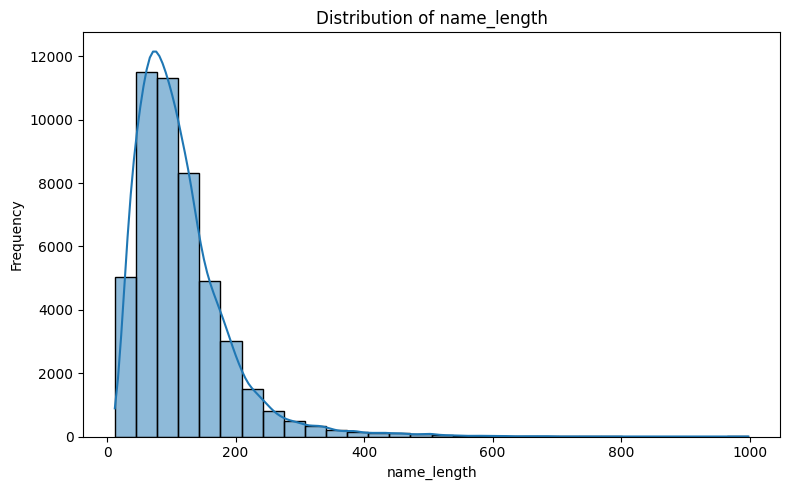

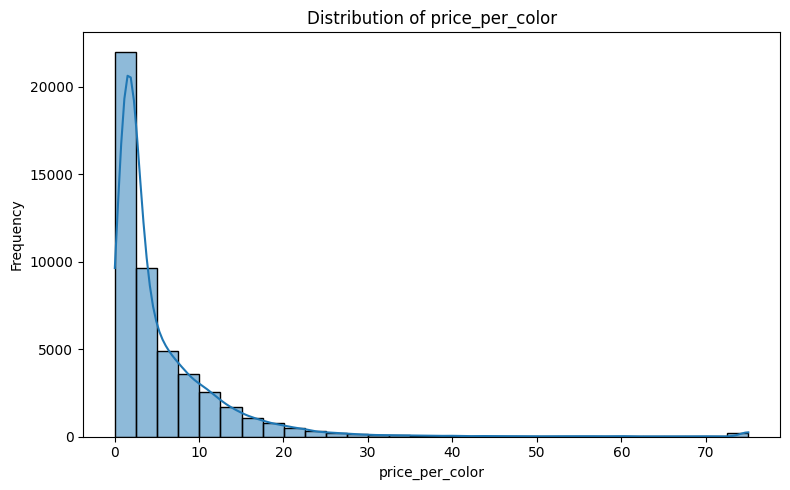

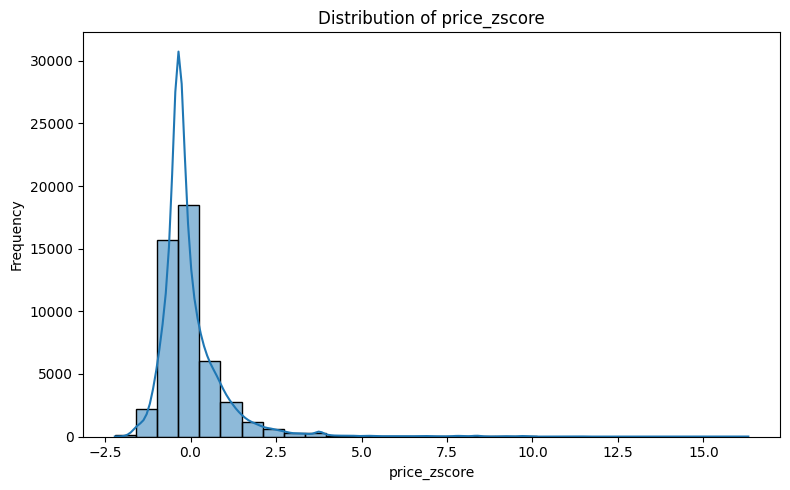

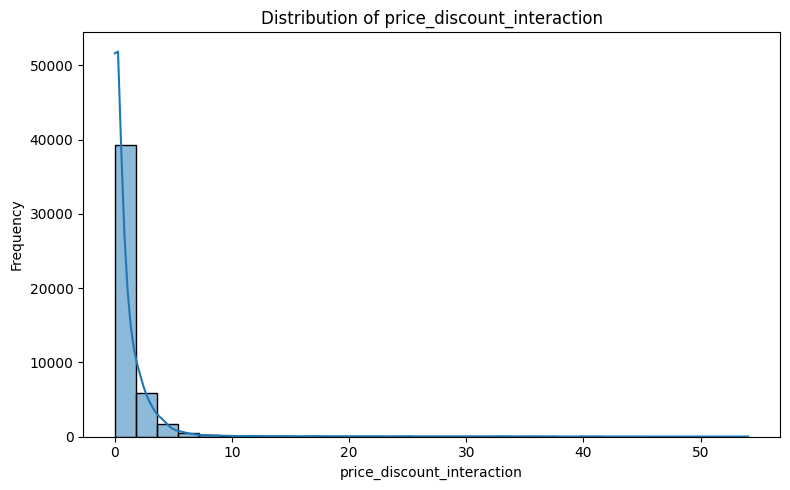

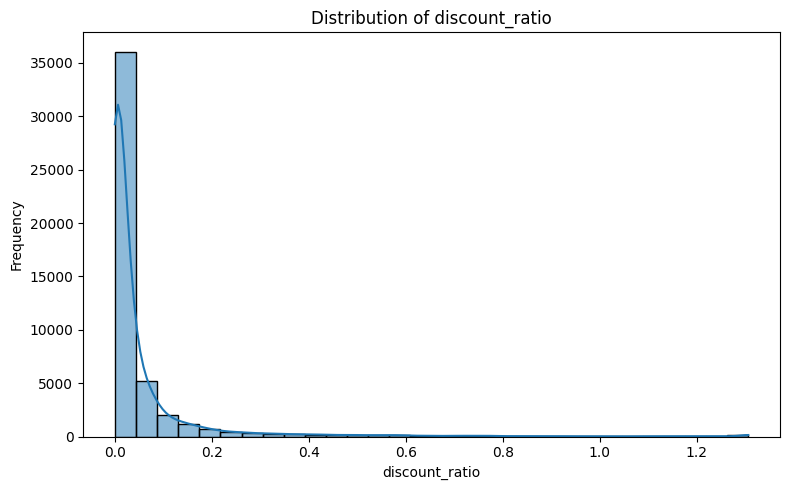

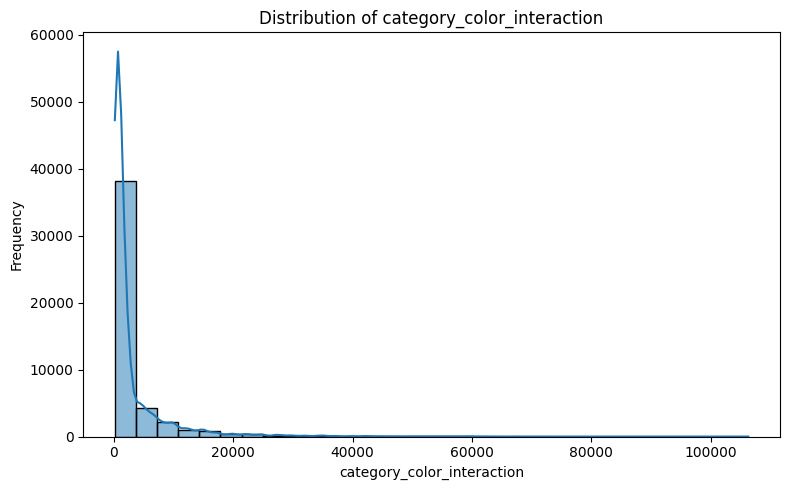

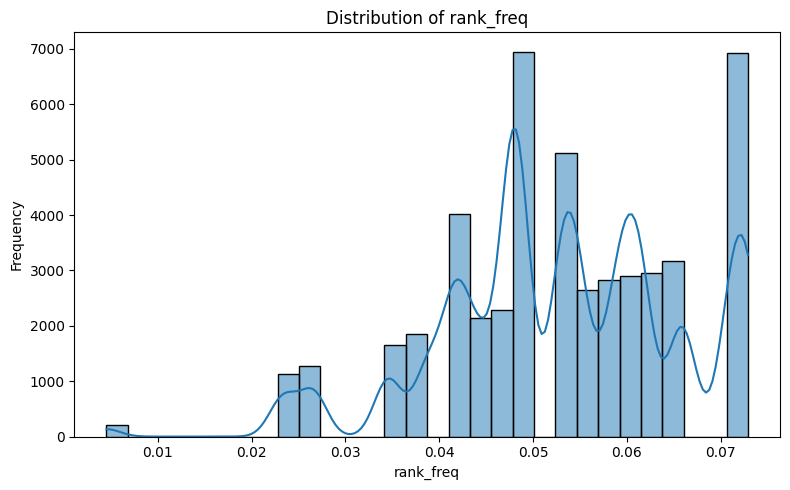

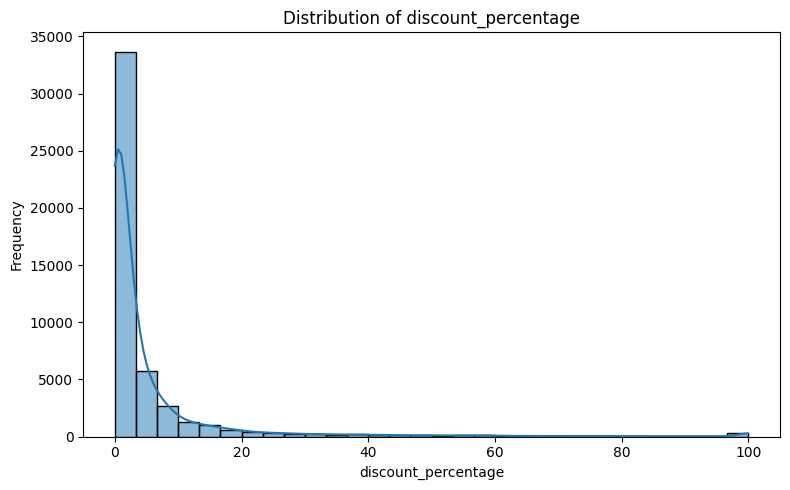

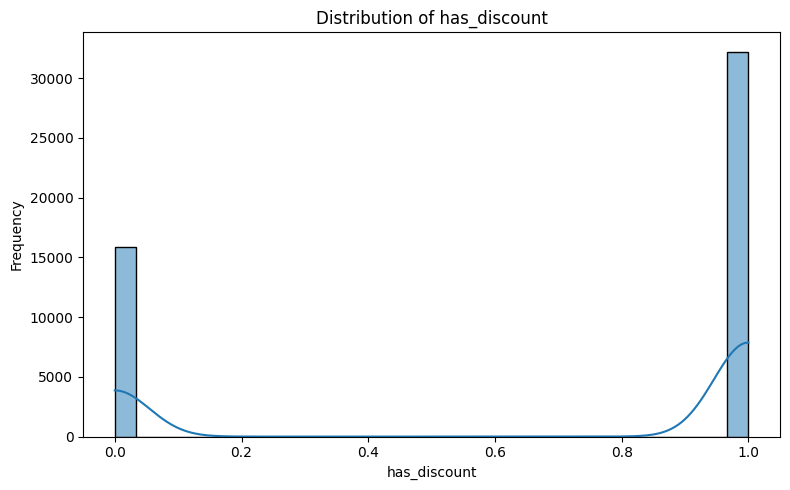

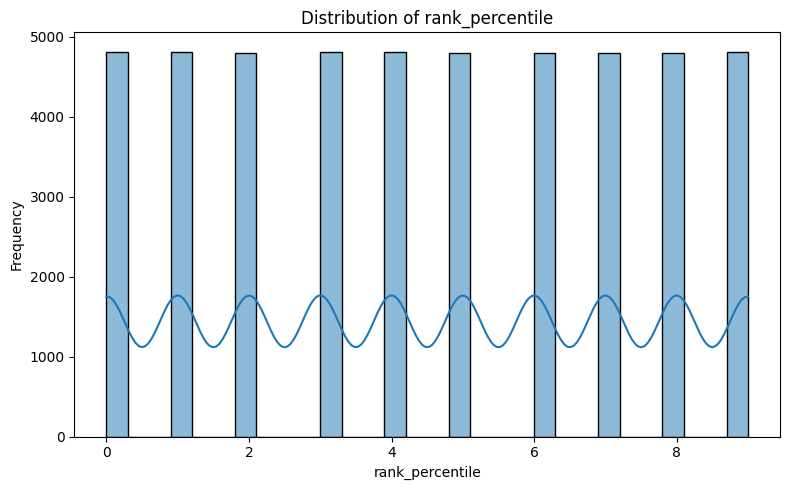

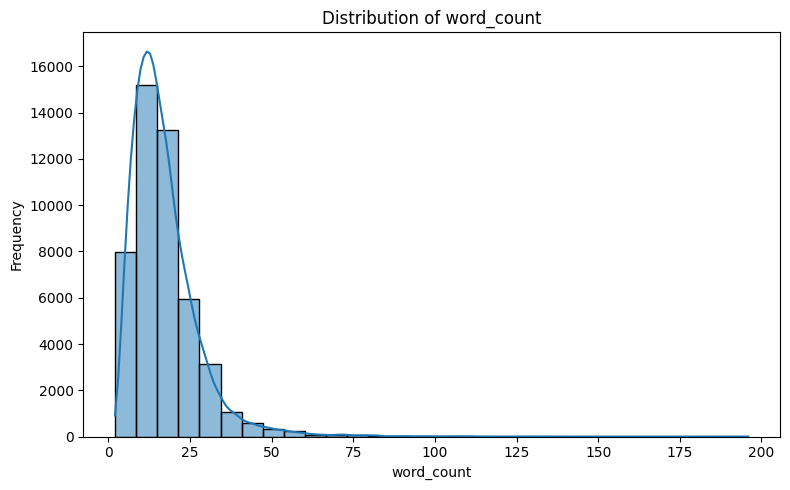

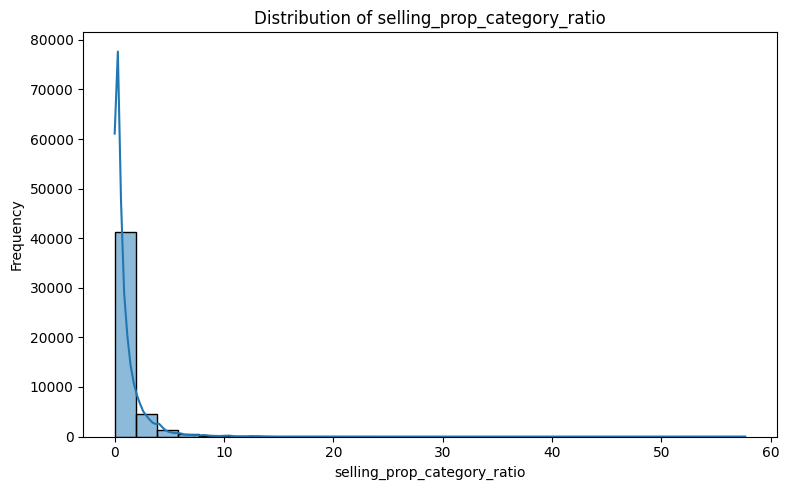

In [39]:
# Plot the distribution of each new feature
for feature in new_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

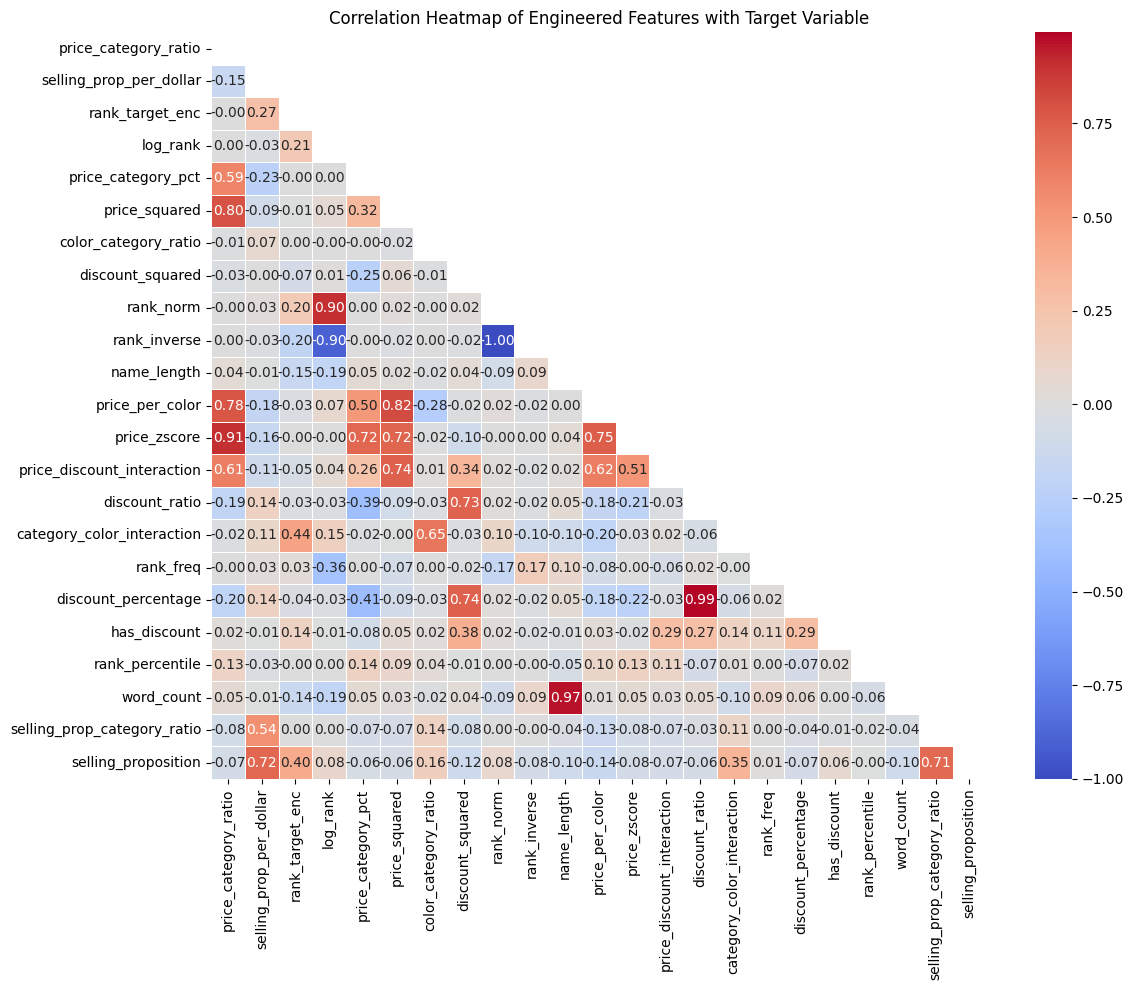

In [41]:
# Add the target variable to the feature list
features_to_correlate = list(new_features) + ['selling_proposition']  # Replace 'selling_proposition' with transformed target if applicable

# Correlation heatmap for engineered features and target variable
plt.figure(figsize=(12, 10))
correlation_matrix = df[features_to_correlate].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Engineered Features with Target Variable")
plt.tight_layout()
plt.show()

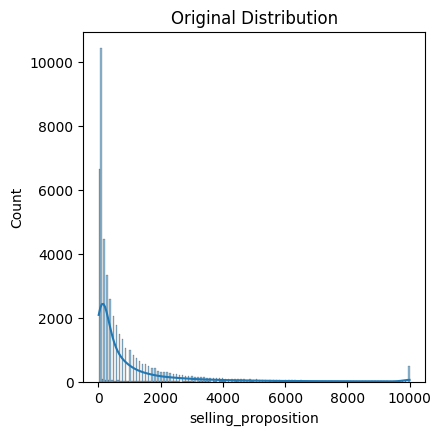

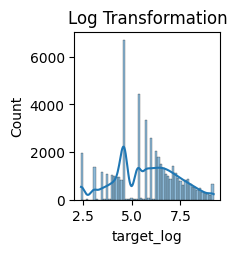

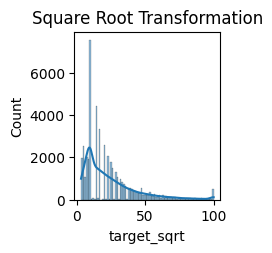

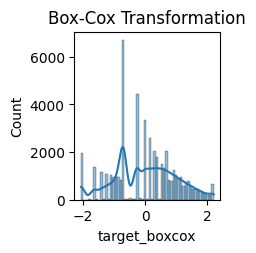

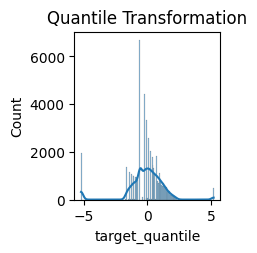

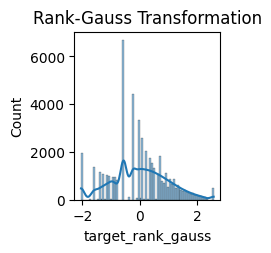

['quantile_transformer.joblib']

In [85]:
# Part 5: Target Transformation
def transform_target(df):
    """Transform the target variable to improve model performance"""
    plt.figure(figsize=(15, 10))

    # Original distribution
    plt.subplot(2, 3, 1)
    sns.histplot(df['selling_proposition'], kde=True)
    plt.title('Original Distribution')
    plt.show()

    # Log transformation
    df['target_log'] = np.log1p(df['selling_proposition'])
    plt.subplot(2, 3, 2)
    sns.histplot(df['target_log'], kde=True)
    plt.title('Log Transformation')
    plt.show()

    # Square root transformation
    df['target_sqrt'] = np.sqrt(df['selling_proposition'])
    plt.subplot(2, 3, 3)
    sns.histplot(df['target_sqrt'], kde=True)
    plt.title('Square Root Transformation')
    plt.show()

    # Box-Cox transformation - Only for positive values
    if (df['selling_proposition'] > 0).all():
        try:
            pt = PowerTransformer(method='box-cox')
            df['target_boxcox'] = pt.fit_transform(df[['selling_proposition']])
            plt.subplot(2, 3, 4)
            sns.histplot(df['target_boxcox'], kde=True)
            plt.title('Box-Cox Transformation')
            plt.show()
        except Exception as e:
            print(f"Could not apply Box-Cox transformation: {e}")
            df['target_boxcox'] = df['target_sqrt']  # Fallback to sqrt

    # Quantile transformation (to normal distribution)
    qt = QuantileTransformer(output_distribution='normal') # Define qt in the function's scope
    df['target_quantile'] = qt.fit_transform(df[['selling_proposition']])
    plt.subplot(2, 3, 5)
    sns.histplot(df['target_quantile'], kde=True)
    plt.title('Quantile Transformation')
    plt.show()

    # Rank-based inverse normal transformation
    def rank_gauss(x):
        """Transform features by rank and apply inverse normal transformation"""
        from scipy.stats import norm
        x = pd.Series(x)
        n = len(x)
        temp = x.rank()
        temp = (temp - 0.5) / n
        temp = norm.ppf(temp)
        return temp

    df['target_rank_gauss'] = rank_gauss(df['selling_proposition'])
    plt.subplot(2, 3, 6)
    sns.histplot(df['target_rank_gauss'], kde=True)
    plt.title('Rank-Gauss Transformation')
    plt.show()
    plt.close()

    # Use the quantile transformation which often works well for skewed data
    return df, df['target_quantile'], qt

df, transformed_target, qt = transform_target(df)
joblib.dump(qt, 'quantile_transformer.joblib')

In the process of improving the distribution of the target variable for modeling, I explored several transformations and visually assessed their effectiveness. The transformations considered were:

Log Transformation: The log transformation was applied to the target variable. The resulting distribution was somewhat improved compared to the original, but still exhibited some skewness and did not closely resemble a normal distribution. There were noticeable peaks and tails that indicated the distribution was not perfectly symmetric.

Square Root Transformation: The square root transformation did not help in reducing the sjewness of the target variable.

Box-Cox Transformation: The Box-Cox transformation, which was applied only to positive values, showed some improvement. The distribution became less skewed, but it still did not achieve the normal distribution shape. There was still some deviation from a perfect bell curve, with no perfect peak.

Quantile Transformation: The quantile transformation was specifically designed to map the data closer to a normal distribution. After applying this transformation, the resulting distribution appeared nearly normal, with a symmetric bell-shaped curve. The peak of the distribution was well-centered, and the tails were more balanced than the other transformations, indicating the closest fit to a normal distribution.

Rank-Gauss Transformation: The rank-based inverse normal transformation also helped in improving the distribution, but it did not produce as ideal a result as the quantile transformation. While it reduced some skewness, the distribution was not as close to a normal shape as that produced by the quantile transformation.

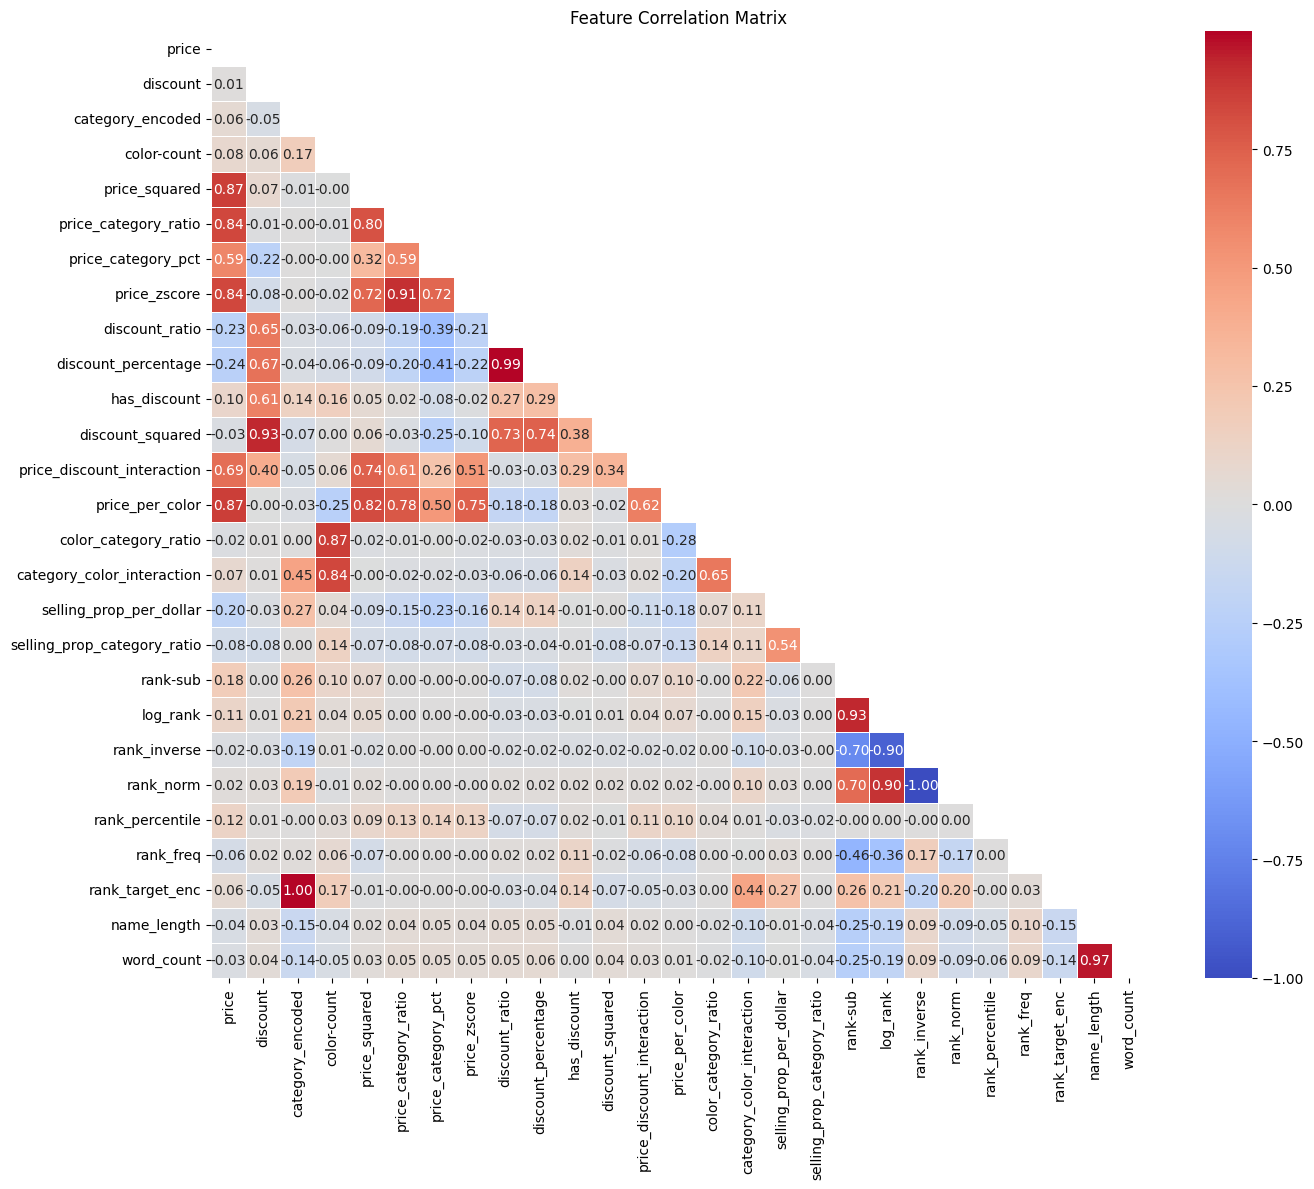

Selected 27 features for modeling


In [45]:
# Part 6: Feature Selection
def select_features(df, target='target_quantile'):
    """Select most relevant features for modeling"""
    # Include all engineered features for selection
    features = [
        # Base features
        'price', 'discount'
    ]

    # Add category if available
    if 'category_encoded' in df.columns:
        features.append('category_encoded')

    # Add color count if available
    if 'color-count' in df.columns:
        features.append('color-count')

    # Add price features
    price_features = ['price_squared']
    if 'price_category_ratio' in df.columns:
        price_features.extend(['price_category_ratio', 'price_category_pct', 'price_zscore'])
    features.extend(price_features)

    # Add discount features
    features.extend(['discount_ratio', 'discount_percentage', 'has_discount', 'discount_squared', 'price_discount_interaction'])

    # Add color features if available
    if 'price_per_color' in df.columns:
        features.append('price_per_color')
    if 'color_category_ratio' in df.columns:
        features.append('color_category_ratio')

    # Add interaction terms if available
    if 'category_color_interaction' in df.columns:
        features.append('category_color_interaction')

    # Add selling proposition features
    features.extend(['selling_prop_per_dollar'])
    if 'selling_prop_category_ratio' in df.columns:
        features.append('selling_prop_category_ratio')

    # Add rank features if available
    if 'rank-sub' in df.columns:
        rank_features = ['rank-sub', 'log_rank', 'rank_inverse']
        if 'rank_norm' in df.columns:
            rank_features.extend(['rank_norm', 'rank_percentile'])
        if 'rank_freq' in df.columns:
            rank_features.append('rank_freq')
        if 'rank_target_enc' in df.columns:
            rank_features.append('rank_target_enc')
        features.extend(rank_features)

    # Add name-based features if available
    if 'name_length' in df.columns:
        features.extend(['name_length', 'word_count'])

    # Create feature dataframe - ensure only columns that actually exist are included
    available_features = [f for f in features if f in df.columns]
    X = df[available_features]

    # Check correlations to identify potential multicollinearity
    plt.figure(figsize=(14, 12))
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    print(f"Selected {len(available_features)} features for modeling")

    return X, df[target]

X, y = select_features(df, target='target_quantile')

In [46]:
# Part 7: Train-Test Split
def split_data(X, y):
    """Split data into training and testing sets with stratification"""
    # For regression, we can stratify by binned target values
    y_binned = pd.qcut(y, q=5, labels=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binned
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(X, y)

                        feature  importance
17  selling_prop_category_ratio    0.808294
2              category_encoded    0.092759
24              rank_target_enc    0.087514
20                 rank_inverse    0.005289
23                    rank_freq    0.001611
15   category_color_interaction    0.001276
21                    rank_norm    0.000451
19                     log_rank    0.000302
18                     rank-sub    0.000284
14         color_category_ratio    0.000242
16      selling_prop_per_dollar    0.000219
26                   word_count    0.000205
13              price_per_color    0.000200
25                  name_length    0.000197
7                  price_zscore    0.000182
0                         price    0.000156
4                 price_squared    0.000151
12   price_discount_interaction    0.000144
5          price_category_ratio    0.000106
9           discount_percentage    0.000096
22              rank_percentile    0.000069
8                discount_ratio 

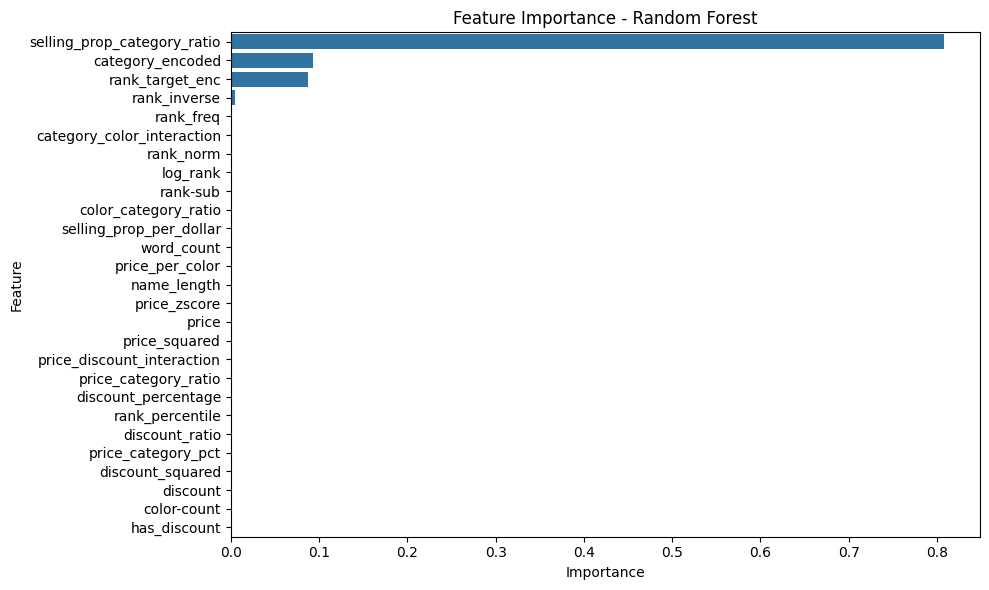

In [48]:
# Part 8: Feature Importance Analysis
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Extract & plot feature importance
importance = (
    pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    })
    .sort_values('importance', ascending=False)
)
print(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

                        feature  importance
17  selling_prop_category_ratio    0.621986
2              category_encoded    0.314374
16      selling_prop_per_dollar    0.020080
6            price_category_pct    0.004269
5          price_category_ratio    0.003634
9           discount_percentage    0.003539
14         color_category_ratio    0.003515
15   category_color_interaction    0.003480
25                  name_length    0.003039
26                   word_count    0.002863
1                      discount    0.002525
0                         price    0.002515
23                    rank_freq    0.002295
7                  price_zscore    0.001949
13              price_per_color    0.001733
8                discount_ratio    0.001730
22              rank_percentile    0.001722
18                     rank-sub    0.001606
3                   color-count    0.001429
12   price_discount_interaction    0.001230
24              rank_target_enc    0.000488
10                 has_discount 

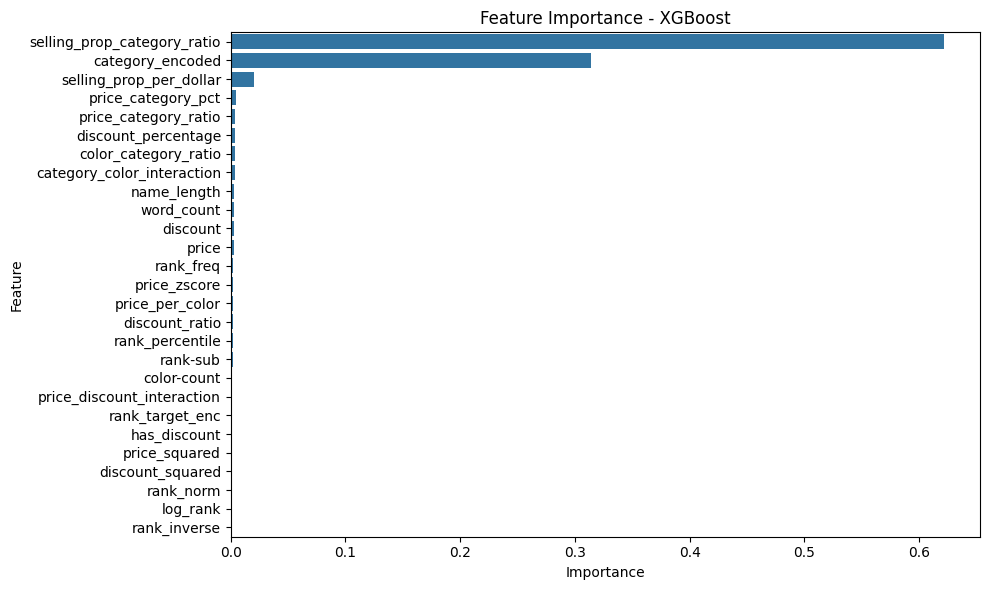

In [49]:
from xgboost import XGBRegressor

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Extract & plot feature importance
xgb_importance = (
    pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    })
    .sort_values('importance', ascending=False)
)
print(xgb_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=xgb_importance)
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

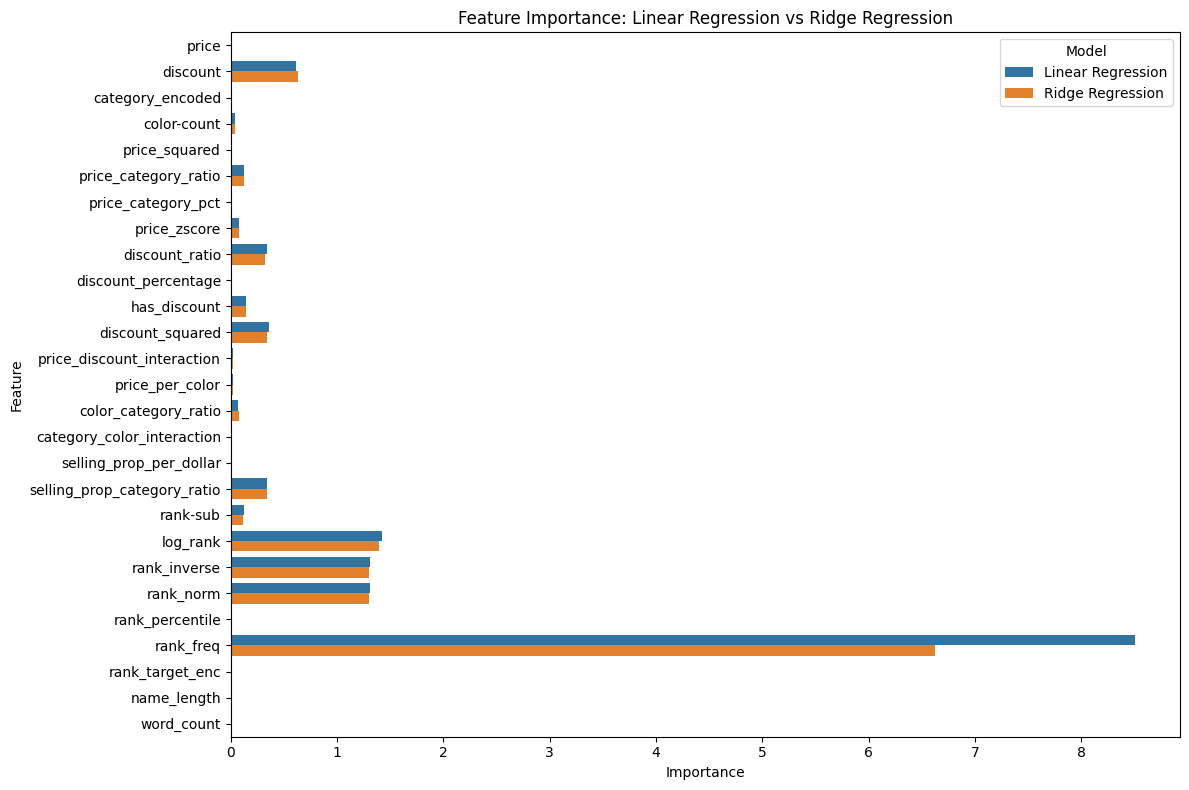

In [50]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0, random_state=42)  # You can adjust alpha for Ridge
ridge_model.fit(X_train, y_train)

# Extract coefficients for both models
importance = pd.DataFrame({
    'feature': X_train.columns,
    'Linear Regression': abs(lr_model.coef_),
    'Ridge Regression': abs(ridge_model.coef_)
})

# Melt the DataFrame for combined plotting
importance_melted = importance.melt(id_vars='feature', var_name='Model', value_name='Importance')

# Plot combined feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='feature', hue='Model', data=importance_melted)
plt.title('Feature Importance: Linear Regression vs Ridge Regression')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Starting RFECV...
Fitting on 27 features...
Fitting on 26 features...
Fitting on 25 features...
Fitting on 24 features...
Fitting on 23 features...
Fitting on 22 features...
Fitting on 21 features...
Fitting on 20 features...
Fitting on 19 features...
Fitting on 18 features...
Fitting on 17 features...
Fitting on 16 features...
Fitting on 15 features...
Fitting on 14 features...
Fitting on 13 features...
Fitting on 12 features...
Fitting on 11 features...
Fitting on 10 features...
Fitting on 9 features...
Fitting on 8 features...
Fitting on 7 features...
Fitting on 6 features...
Fitting on 5 features...
Fitting on 5 features...
Optimal number of features: 5
Selected features: ['price', 'category_encoded', 'selling_prop_per_dollar', 'selling_prop_category_ratio', 'rank_target_enc']


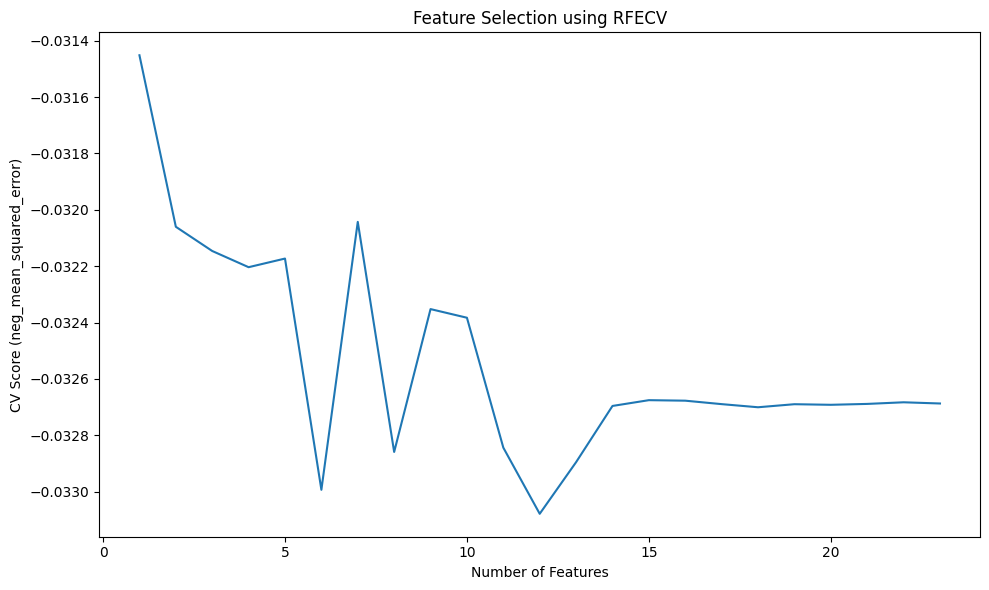

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

# Custom estimator wrapper with tqdm
class TQDMGradientBoostingRegressor(GradientBoostingRegressor):
    def fit(self, X, y, sample_weight=None, monitor=None):
        tqdm.write(f"Fitting on {X.shape[1]} features...")
        return super().fit(X, y, sample_weight=sample_weight, monitor=monitor)

def rfecv_feature_selection(X_train, y_train):
    """Select optimal features using Recursive Feature Elimination with Cross-Validation"""
    estimator = TQDMGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

    # Create RFECV object
    selector = RFECV(
        estimator=estimator,
        step=1,
        cv=KFold(5, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error',
        min_features_to_select=5,
        n_jobs=-1,
        verbose=0  # We'll rely on tqdm instead
    )

    tqdm.write("Starting RFECV...")
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_].tolist()

    print(f"Optimal number of features: {selector.n_features_}")
    print(f"Selected features: {selected_features}")

    # Plot number of features vs CV score
    # Access cv_results_ instead of grid_scores_
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
    plt.xlabel('Number of Features')
    plt.ylabel('CV Score (neg_mean_squared_error)')
    plt.title('Feature Selection using RFECV')
    plt.tight_layout()
    plt.savefig('rfecv_feature_selection.png')
    plt.show()

    return selected_features, selector

selected_features, selector = rfecv_feature_selection(X_train, y_train)
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [86]:
joblib.dump(selected_features, 'selected_features.joblib')

['selected_features.joblib']

In [53]:
X_train.to_csv('X_train_selected.csv', index=False)
X_test.to_csv('X_test_selected.csv', index=False)

In [55]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
import xgboost as xgb
import numpy as np
from joblib import dump, load
import os

In [56]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate model performance and print metrics"""
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Print metrics
    print(f"\n{model_name} Model Performance:")
    print(f"Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}")
    print(f"Cross-Validation (R²) Scores: {cv_scores}")
    print(f"Mean CV R² Score: {cv_scores.mean():.4f}")

In [57]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate Linear Regression
evaluate_model(lr_model, X_train, y_train, X_test, y_test, "Linear Regression")

# Save the model
dump(lr_model, "lr_model.joblib")



Linear Regression Model Performance:
Train R²: 0.4365, Train RMSE: 1.0914, Train MAE: 0.6451
Test R²: 0.4408, Test RMSE: 1.0674, Test MAE: 0.6341
Cross-Validation (R²) Scores: [0.45025234 0.42336704 0.45150584 0.41434113 0.4361737 ]
Mean CV R² Score: 0.4351


['lr_model.joblib']

In [58]:
# Train Ridge Regression
ridge_model = Ridge(alpha=1.0)  # You can tune alpha for regularization
ridge_model.fit(X_train, y_train)

# Evaluate Ridge Regression
evaluate_model(ridge_model, X_train, y_train, X_test, y_test, "Ridge Regression")

# Save the model
dump(ridge_model, "ridge_model.joblib")


Ridge Regression Model Performance:
Train R²: 0.4365, Train RMSE: 1.0914, Train MAE: 0.6451
Test R²: 0.4408, Test RMSE: 1.0674, Test MAE: 0.6341
Cross-Validation (R²) Scores: [0.4502522  0.42336788 0.45150483 0.41434143 0.43617403]
Mean CV R² Score: 0.4351


['ridge_model.joblib']

In [59]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
evaluate_model(xgb_model, X_train, y_train, X_test, y_test, "XGBoost")

# Save the model
dump(xgb_model, "xgb_model.joblib")


XGBoost Model Performance:
Train R²: 0.9845, Train RMSE: 0.1811, Train MAE: 0.0765
Test R²: 0.9843, Test RMSE: 0.1790, Test MAE: 0.0758
Cross-Validation (R²) Scores: [0.9799603  0.98333907 0.98622885 0.98489333 0.98166096]
Mean CV R² Score: 0.9832


['xgb_model.joblib']

In [60]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
evaluate_model(rf_model, X_train, y_train, X_test, y_test, "Random Forest")

# Save the model
dump(rf_model, "rf_model.joblib")


Random Forest Model Performance:
Train R²: 0.9993, Train RMSE: 0.0387, Train MAE: 0.0024
Test R²: 0.9986, Test RMSE: 0.0540, Test MAE: 0.0037
Cross-Validation (R²) Scores: [0.9973539  0.99736479 0.99766144 0.9983908  0.9971798 ]
Mean CV R² Score: 0.9976


['rf_model.joblib']

In [61]:
# Load previously trained models
lr_model = load("lr_model.joblib")
ridge_model = load("ridge_model.joblib")
xgb_model = load("xgb_model.joblib")
rf_model = load("rf_model.joblib")

# Train Ensemble Voting
ensemble = VotingRegressor(
    estimators=[('lr', lr_model), ('ridge', ridge_model), ('xgb', xgb_model), ('rf', rf_model)]
)
ensemble.fit(X_train, y_train)

# Evaluate Ensemble Voting
evaluate_model(ensemble, X_train, y_train, X_test, y_test, "Ensemble Voting")

# Save the model
dump(ensemble, "ensemble.joblib")


Ensemble Voting Model Performance:
Train R²: 0.8510, Train RMSE: 0.5612, Train MAE: 0.3312
Test R²: 0.8518, Test RMSE: 0.5495, Test MAE: 0.3256
Cross-Validation (R²) Scores: [0.85439881 0.84570194 0.85374737 0.84463888 0.85153429]
Mean CV R² Score: 0.8500


['ensemble.joblib']

In [66]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [68]:
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: L1-based Feature Selection (Lasso) before PCA
print("\nApplying L1-based feature selection with Lasso...")
# Change max_features to be less than or equal to the number of features in your dataset
lasso_selector = SelectFromModel(Lasso(alpha=0.1, random_state=42), max_features=5) # Changed max_features to 5
lasso_selector.fit(X_train_scaled, y_train)
selected_features = X_train.columns[lasso_selector.get_support()].tolist()
print(f"Selected {len(selected_features)} features with Lasso: {selected_features}")

# Transform data with selected features
X_train_lasso = lasso_selector.transform(X_train_scaled)
X_test_lasso = lasso_selector.transform(X_test_scaled)

Standardizing features...

Applying L1-based feature selection with Lasso...
Selected 4 features with Lasso: ['price', 'selling_prop_per_dollar', 'selling_prop_category_ratio', 'rank_target_enc']



Applying PCA on Lasso-selected features...
Number of PCA components: 4
Explained variance ratio: 1.0000
Explained variance per component: [0.41350229 0.26730769 0.22519197 0.09399805]


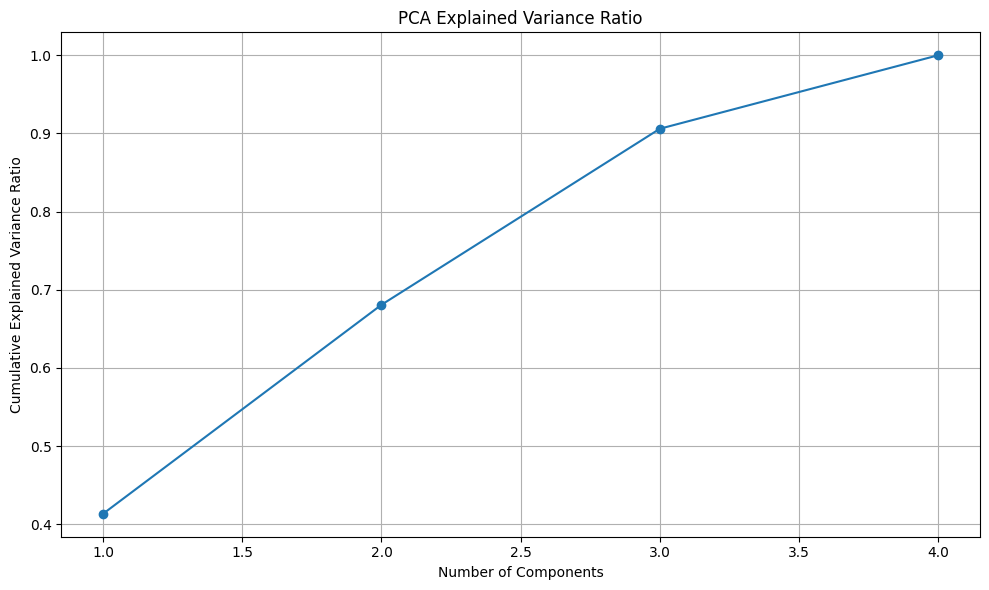

In [69]:
print("\nApplying PCA on Lasso-selected features...")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_lasso)
X_test_pca = pca.transform(X_test_lasso)

# Print PCA details
print(f"Number of PCA components: {pca.n_components_}")
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")
print(f"Explained variance per component: {pca.explained_variance_ratio_}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
def tune_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

In [71]:
print("\nTraining Linear Regression with PCA...")
lr_model_pca = LinearRegression()
lr_model_pca.fit(X_train_pca, y_train)
evaluate_model(lr_model_pca, X_train_pca, y_train, X_test_pca, y_test, "Linear Regression with PCA")
joblib.dump(lr_model_pca, "lr_model_pca.joblib")
print("Saved Linear Regression with PCA to 'lr_model_pca.joblib'")


Training Linear Regression with PCA...

Linear Regression with PCA Model Performance:
Train R²: 0.4365, Train RMSE: 1.0914, Train MAE: 0.6451
Test R²: 0.4408, Test RMSE: 1.0674, Test MAE: 0.6341
Cross-Validation (R²) Scores: [0.45025296 0.42345938 0.45154185 0.41433094 0.43616302]
Mean CV R² Score: 0.4351
Saved Linear Regression with PCA to 'lr_model_pca.joblib'


In [72]:
print("\nTuning and training Lasso Regression with PCA...")
lasso_model = Lasso(random_state=42)
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
lasso_model_pca = tune_model(lasso_model, lasso_param_grid, X_train_pca, y_train)
evaluate_model(lasso_model_pca, X_train_pca, y_train, X_test_pca, y_test, "Lasso Regression with PCA")
joblib.dump(lasso_model_pca, "lasso_model_pca.joblib")
print("Saved Lasso Regression with PCA to 'lasso_model_pca.joblib'")


Tuning and training Lasso Regression with PCA...
Best parameters for Lasso: {'alpha': 0.01}

Lasso Regression with PCA Model Performance:
Train R²: 0.4363, Train RMSE: 1.0916, Train MAE: 0.6444
Test R²: 0.4411, Test RMSE: 1.0671, Test MAE: 0.6331
Cross-Validation (R²) Scores: [0.45016482 0.42512994 0.45010526 0.41457021 0.43631584]
Mean CV R² Score: 0.4353
Saved Lasso Regression with PCA to 'lasso_model_pca.joblib'


In [73]:
print("\nTuning and training Ridge Regression with PCA...")
ridge_model = Ridge(random_state=42)
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}
ridge_model_pca = tune_model(ridge_model, ridge_param_grid, X_train_pca, y_train)
evaluate_model(ridge_model_pca, X_train_pca, y_train, X_test_pca, y_test, "Ridge Regression with PCA")
joblib.dump(ridge_model_pca, "ridge_model_pca.joblib")
print("Saved Ridge Regression with PCA to 'ridge_model_pca.joblib'")


Tuning and training Ridge Regression with PCA...
Best parameters for Ridge: {'alpha': 100.0}

Ridge Regression with PCA Model Performance:
Train R²: 0.4365, Train RMSE: 1.0914, Train MAE: 0.6451
Test R²: 0.4409, Test RMSE: 1.0673, Test MAE: 0.6341
Cross-Validation (R²) Scores: [0.45022309 0.42367949 0.45124312 0.41441603 0.43626231]
Mean CV R² Score: 0.4352
Saved Ridge Regression with PCA to 'ridge_model_pca.joblib'


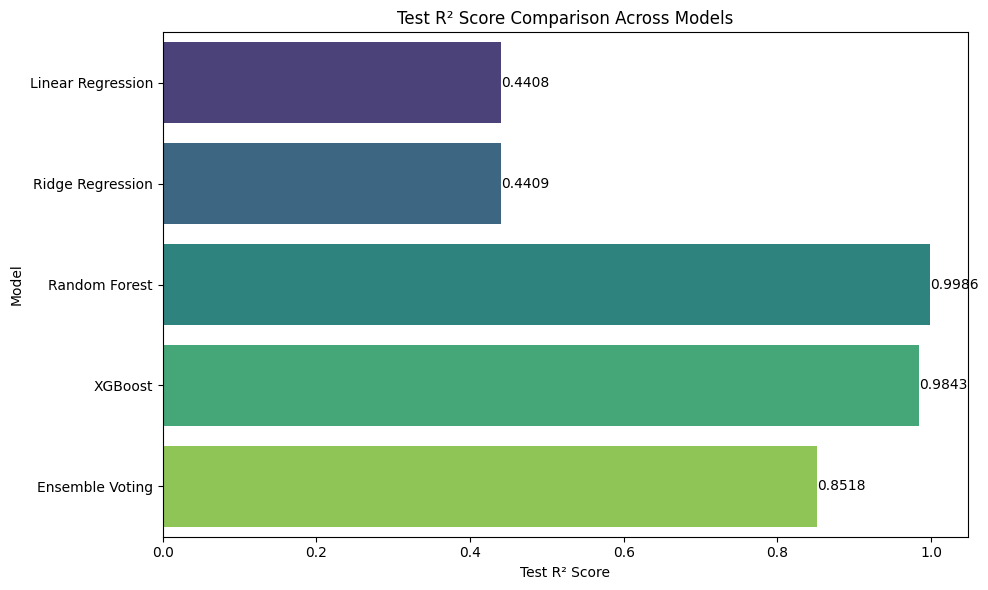


Test R² Scores:
Linear Regression   : 0.4408
Ridge Regression    : 0.4409
Random Forest       : 0.9986
XGBoost             : 0.9843
Ensemble Voting     : 0.8518


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Calculate test R² scores for all models
model_dict = {
    'Linear Regression': lr_model_pca,
    'Ridge Regression': ridge_model_pca,
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'Ensemble Voting': ensemble
}

test_scores = {
    name: r2_score(y_test, model.predict(X_test_pca))
    if name in ['Linear Regression', 'Ridge Regression','Lasso Regression']  # Models trained with PCA
    else r2_score(y_test, model.predict(X_test))  # Other models
    for name, model in model_dict.items()
}

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(test_scores.values()), y=list(test_scores.keys()), palette='viridis')
plt.xlabel('Test R² Score')
plt.ylabel('Model')
plt.title('Test R² Score Comparison Across Models')
for i, score in enumerate(test_scores.values()):
    plt.text(score, i, f'{score:.4f}', va='center', ha='left', color='black')
plt.tight_layout()
plt.savefig('r2_comparison.png')
plt.show()

# Print scores
print("\nTest R² Scores:")
for name, score in test_scores.items():
    print(f"{name:20s}: {score:.4f}")


### Learning Curve for Linear Regression ###


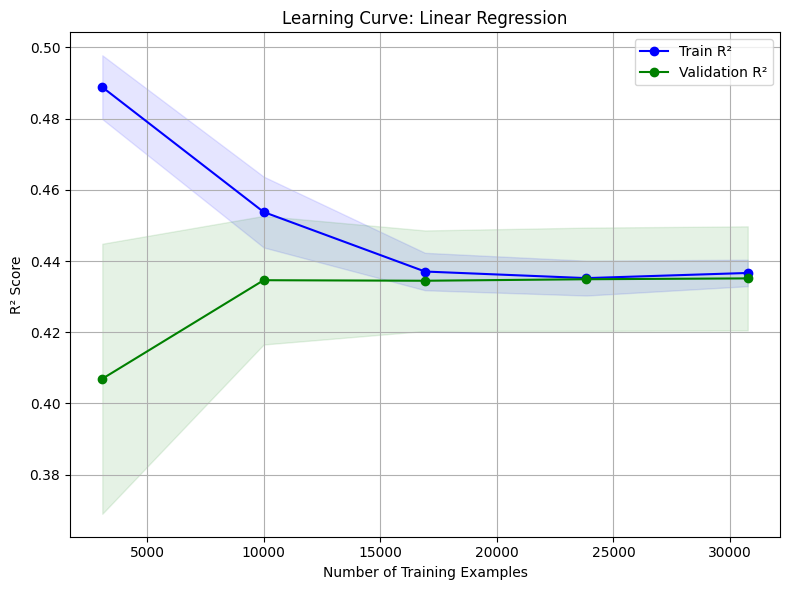

⚠️ Linear Regression appears underfitting (low R² on both training & validation).

### Learning Curve for Ridge Regression ###


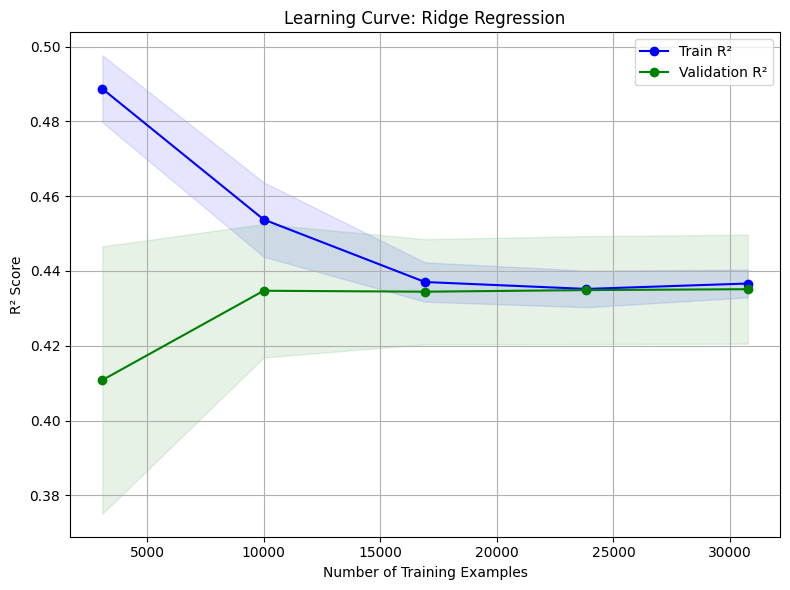

⚠️ Ridge Regression appears underfitting (low R² on both training & validation).

### Learning Curve for Random Forest ###


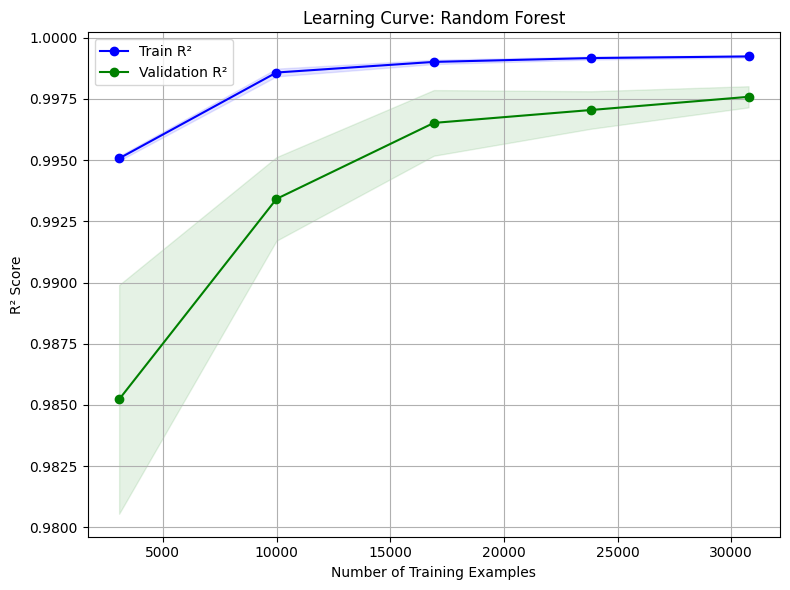

✅ Random Forest has a good bias-variance balance.

### Learning Curve for XGBoost ###


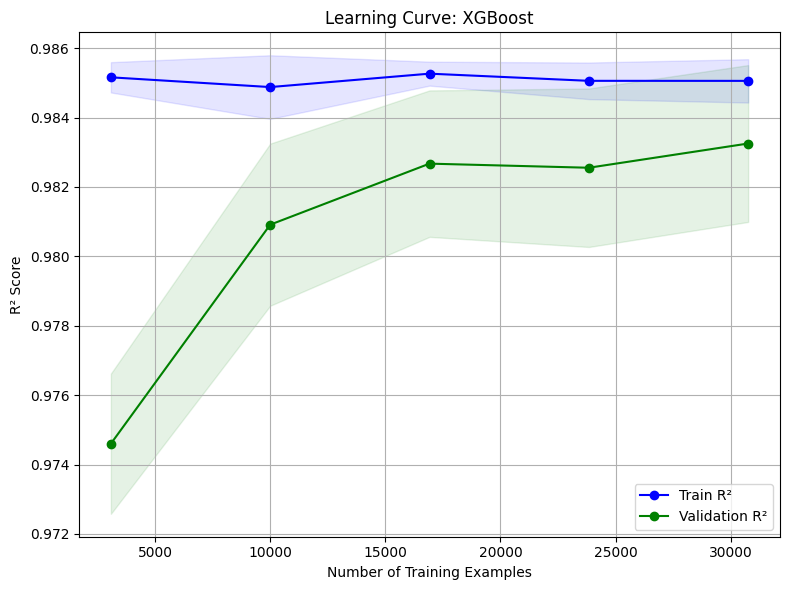

✅ XGBoost has a good bias-variance balance.

### Learning Curve for Ensemble Voting ###


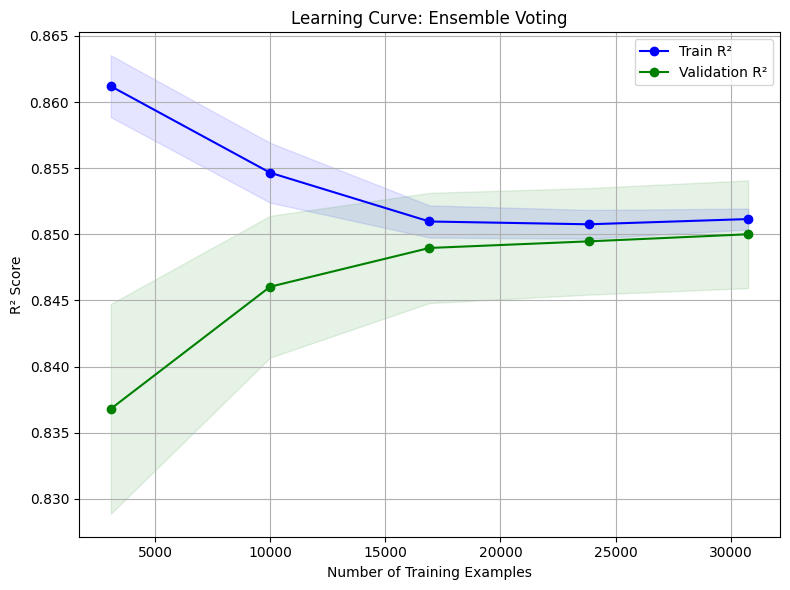

✅ Ensemble Voting has a good bias-variance balance.


In [76]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curves(model, name, X_train, y_train, cv=5):
    """Plot learning curves for a given model"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring='r2',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Train R²', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation R²', color='green')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='green')
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('R² Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'learning_curve_{name.lower().replace(" ", "_")}.png')
    plt.show()

    # Diagnose
    if train_mean[-1] < 0.5 and val_mean[-1] < 0.5:
        print(f"⚠️ {name} appears underfitting (low R² on both training & validation).")
    elif (train_mean[-1] - val_mean[-1]) > 0.1:
        print(f"⚠️ {name} appears overfitting (Train R²: {train_mean[-1]:.4f}, Val R²: {val_mean[-1]:.4f}).")
    else:
        print(f"✅ {name} has a good bias-variance balance.")

# Plot learning curves for all models
for name, model in model_dict.items():
    print(f"\n### Learning Curve for {name} ###")
    plot_learning_curves(model, name, X_train, y_train, cv=5)


Residual Analysis for Linear Regression


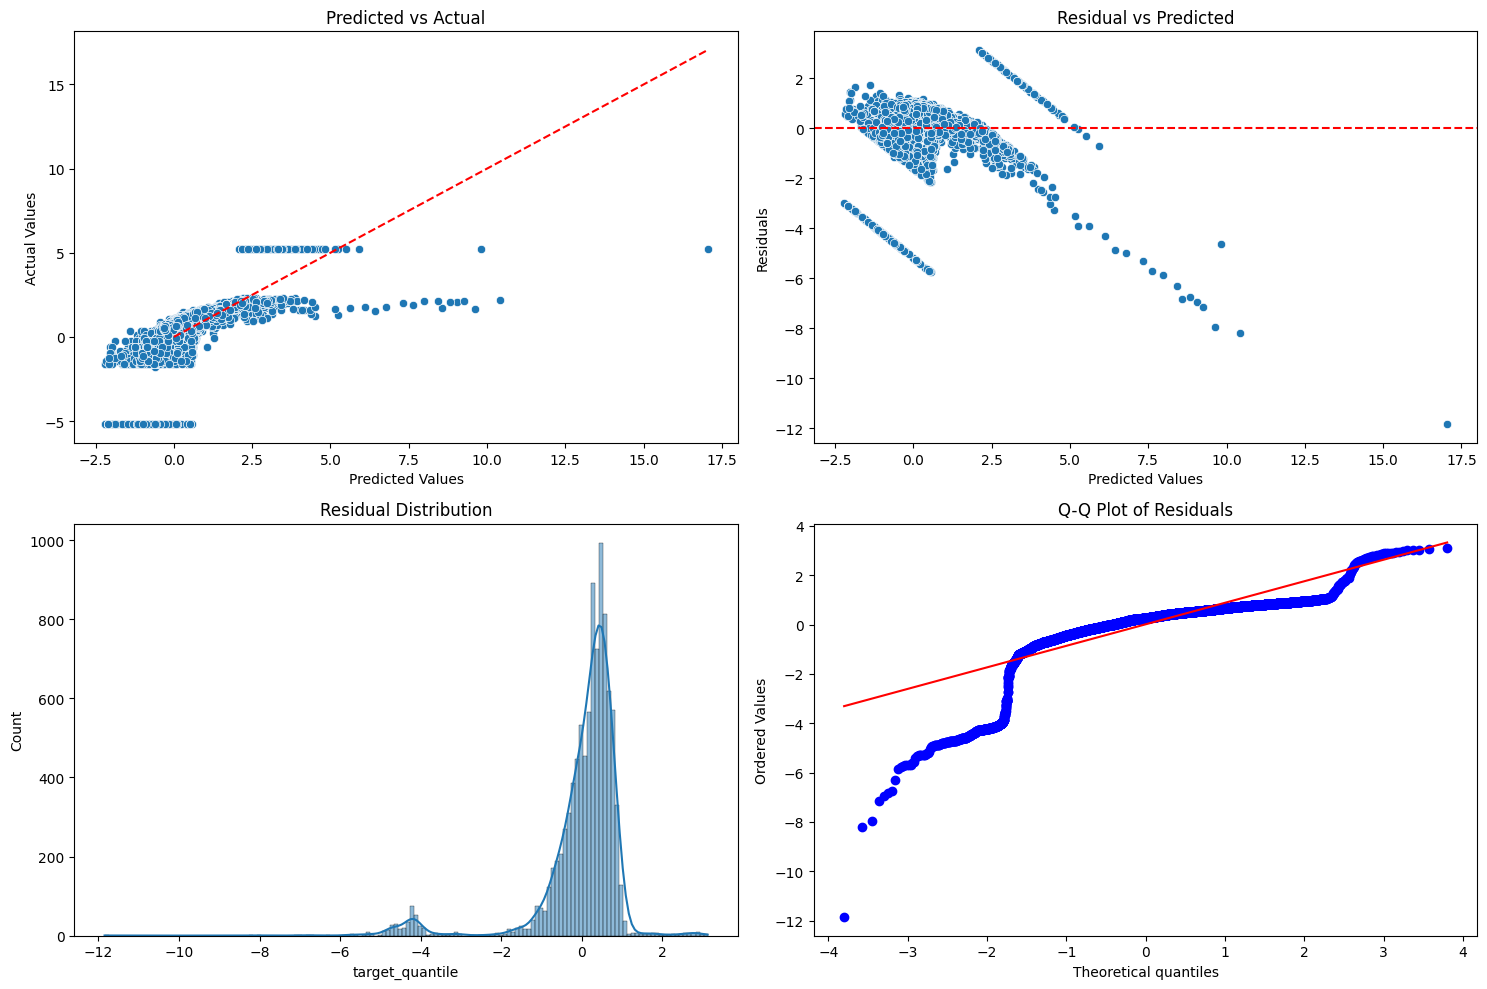


Sample predictions for Linear Regression:
         Actual  Predicted  Residual
13836 -0.580524  -0.667663  0.087140
1495  -1.418119  -0.558358 -0.859761
45524  0.227777  -0.188552  0.416328
37205  0.427976  -0.184013  0.611989
2822   0.653377   0.484491  0.168886
Predictions saved to 'predictions_linear_regression.csv'

Residual Analysis for Ridge Regression


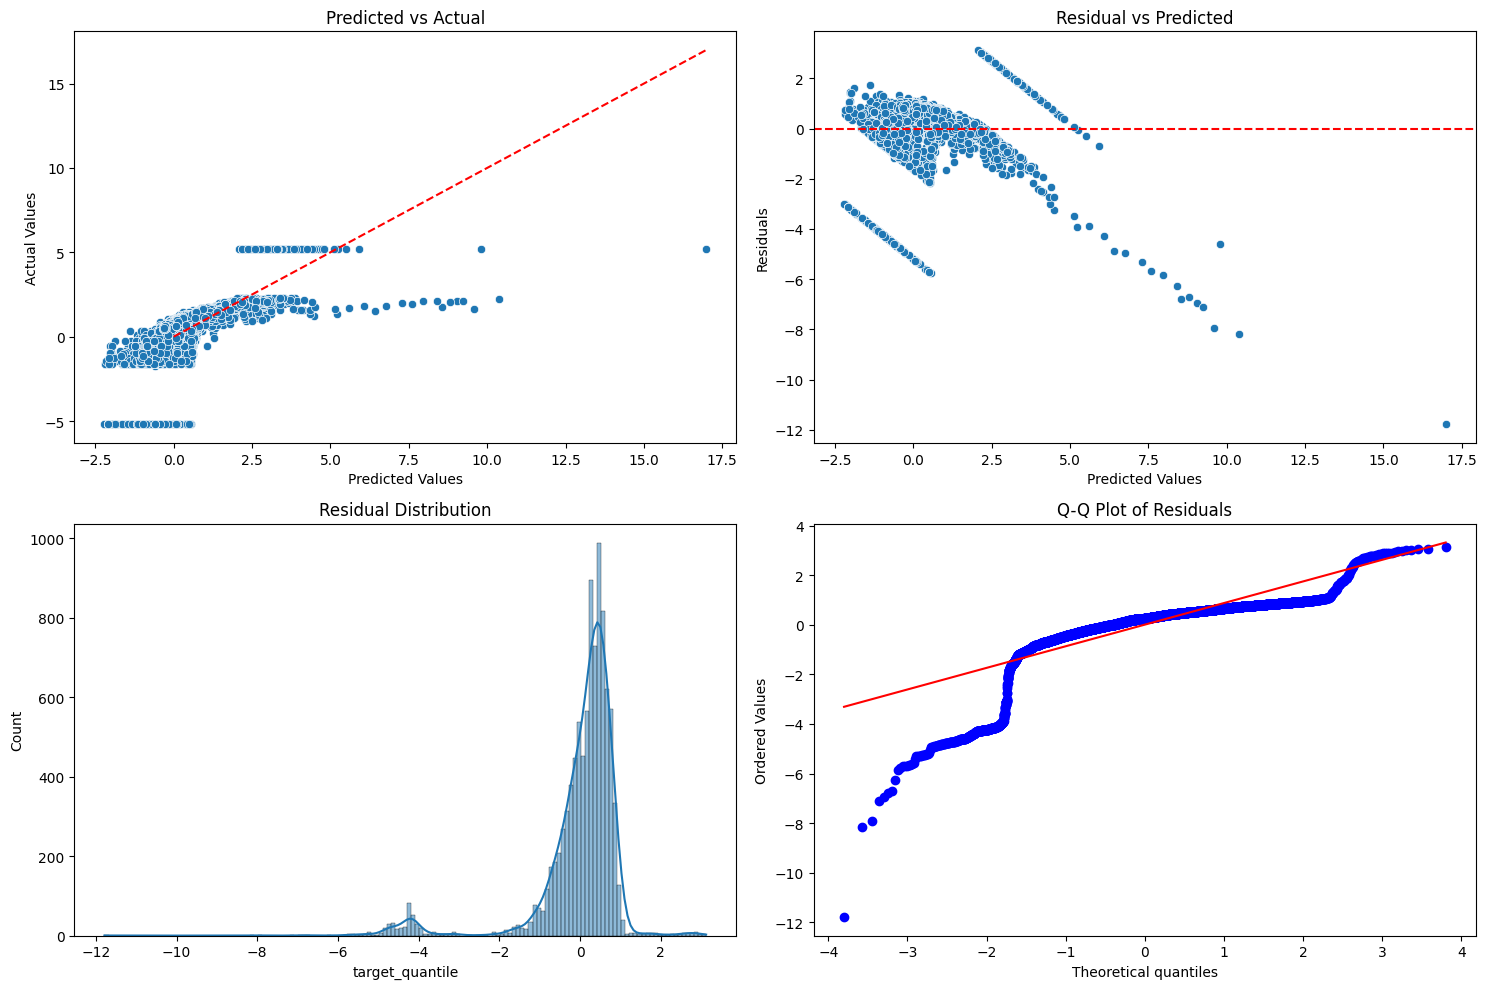


Sample predictions for Ridge Regression:
         Actual  Predicted  Residual
13836 -0.580524  -0.666410  0.085887
1495  -1.418119  -0.557479 -0.860640
45524  0.227777  -0.188291  0.416068
37205  0.427976  -0.184327  0.612303
2822   0.653377   0.483610  0.169767
Predictions saved to 'predictions_ridge_regression.csv'

Residual Analysis for Random Forest


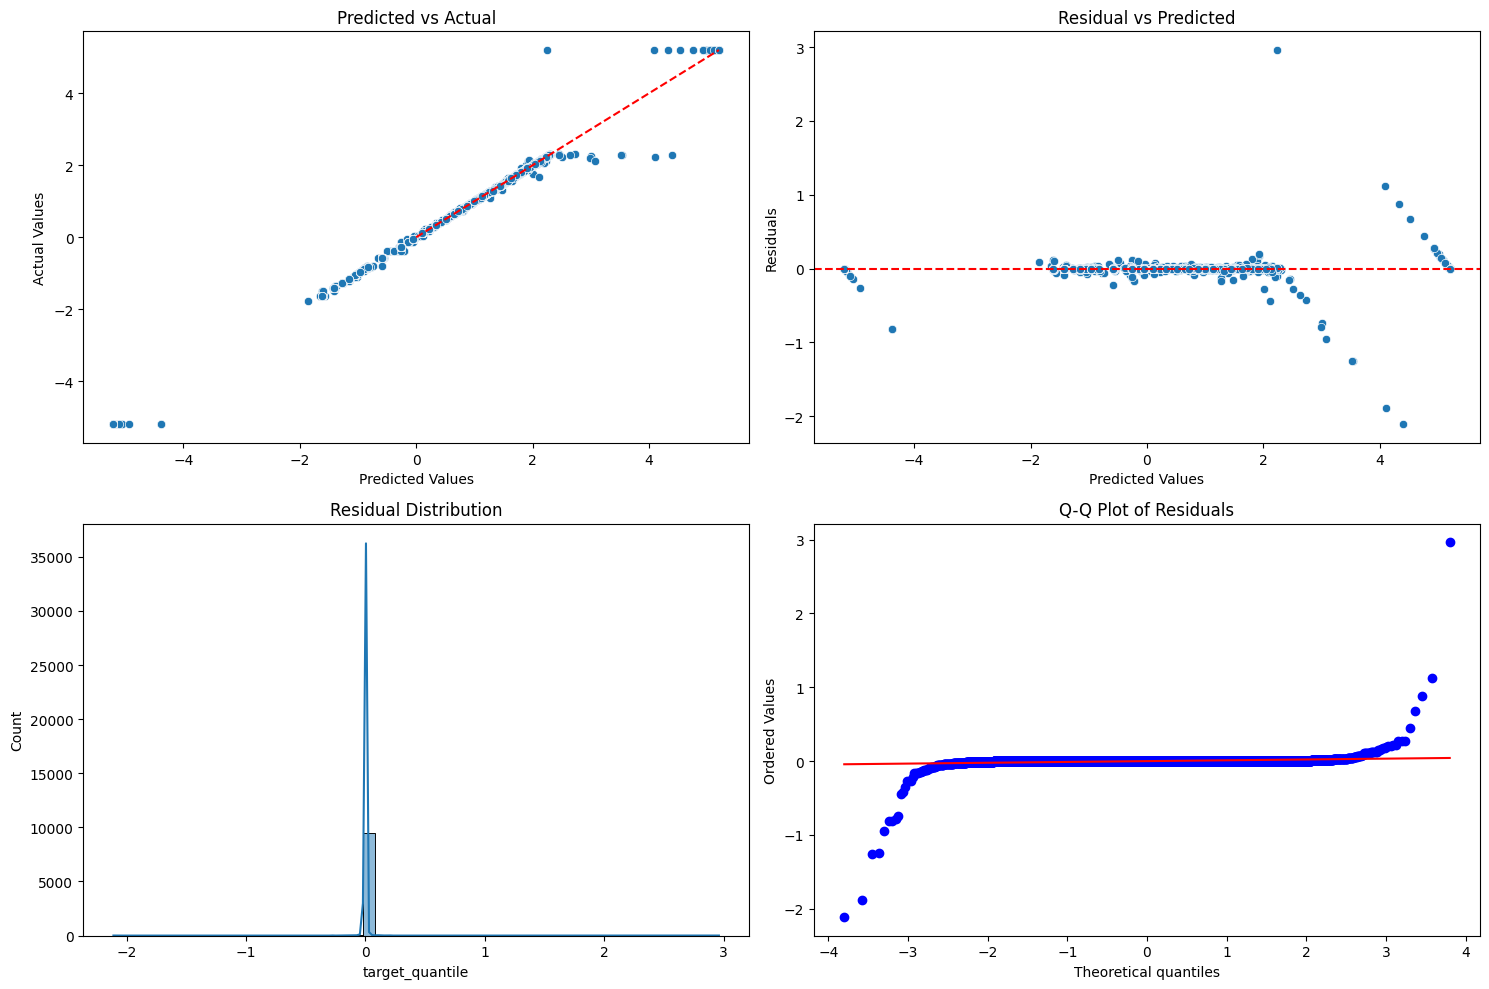


Sample predictions for Random Forest:
         Actual  Predicted      Residual
13836 -0.580524  -0.580524 -4.329870e-15
1495  -1.418119  -1.401686 -1.643220e-02
45524  0.227777   0.227777  4.163336e-16
37205  0.427976   0.427976  3.497203e-15
2822   0.653377   0.653599 -2.221182e-04
Predictions saved to 'predictions_random_forest.csv'

Residual Analysis for XGBoost


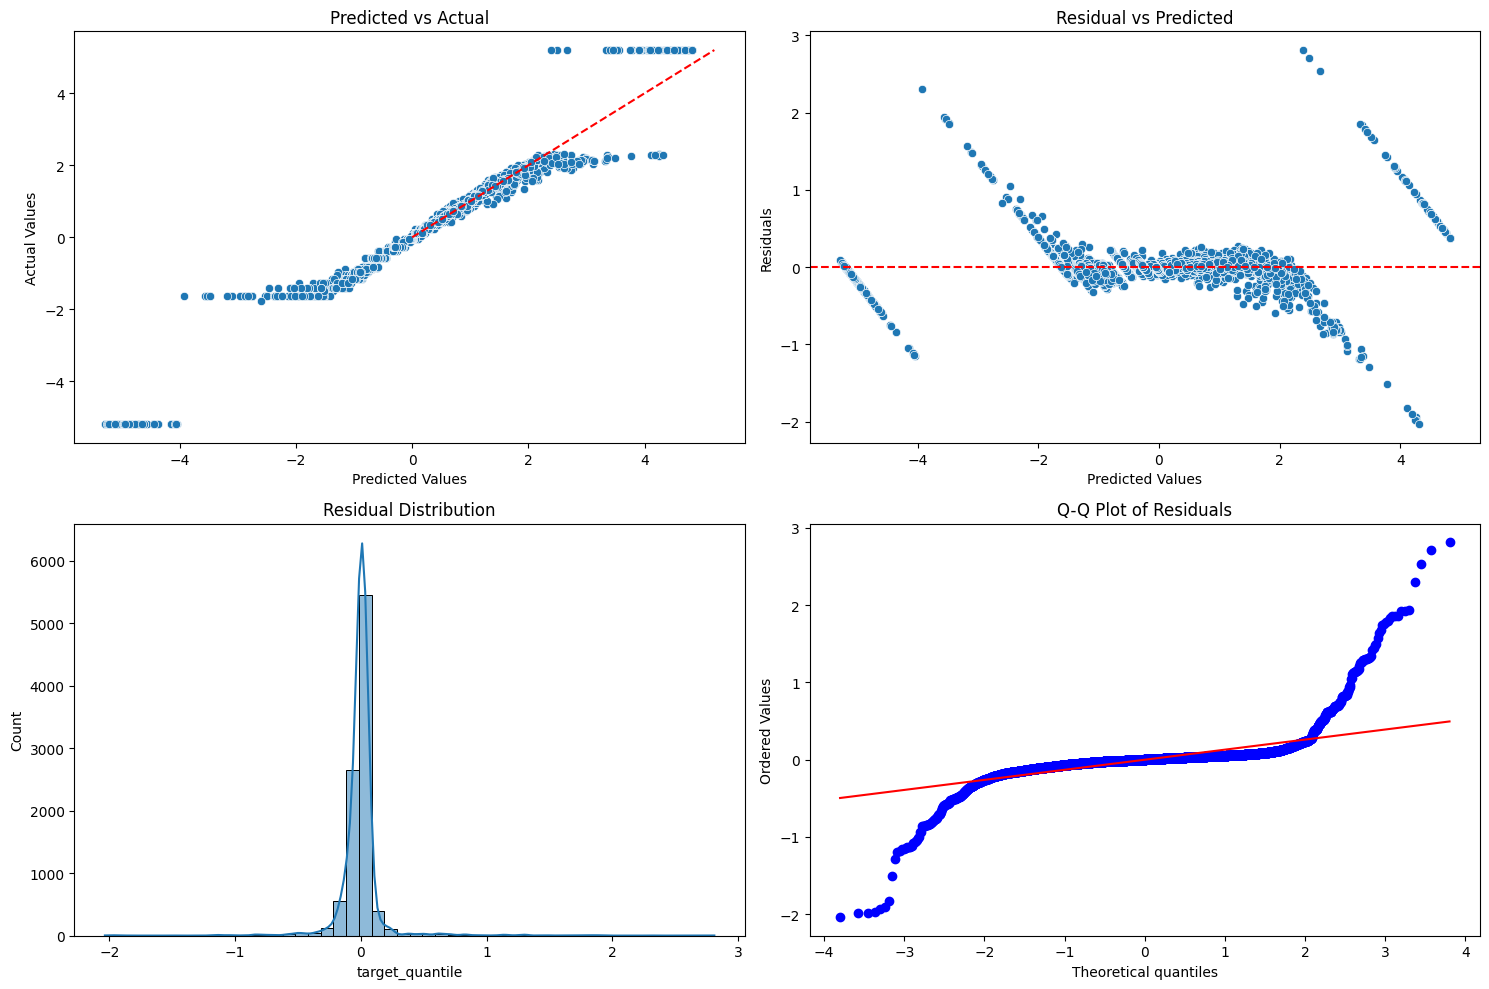


Sample predictions for XGBoost:
         Actual  Predicted  Residual
13836 -0.580524  -0.621967  0.041444
1495  -1.418119  -1.286624 -0.131495
45524  0.227777   0.232075 -0.004298
37205  0.427976   0.423733  0.004243
2822   0.653377   0.629505  0.023871
Predictions saved to 'predictions_xgboost.csv'

Residual Analysis for Ensemble Voting


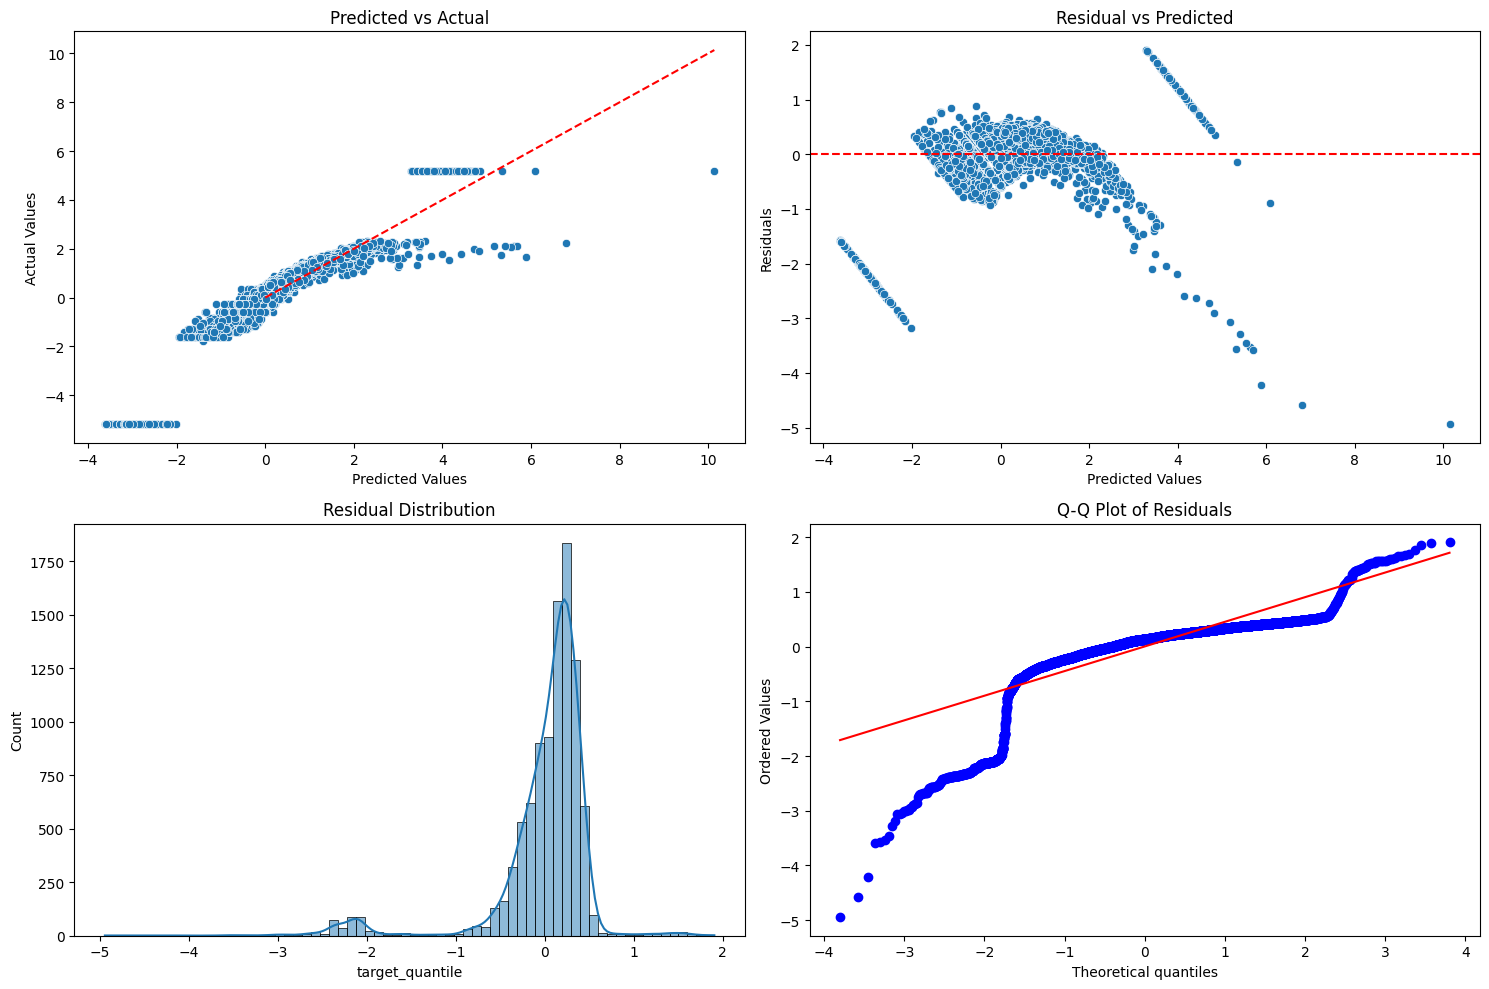


Sample predictions for Ensemble Voting:
         Actual  Predicted  Residual
13836 -0.580524  -0.634386  0.053863
1495  -1.418119  -0.951213 -0.466906
45524  0.227777   0.020799  0.206977
37205  0.427976   0.121147  0.306828
2822   0.653377   0.562687  0.090690
Predictions saved to 'predictions_ensemble_voting.csv'


In [80]:
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np

def residual_analysis(model, name, X_test, X_test_pca, y_test):  # Add X_test_pca as argument
    """Generate residual analysis plots for a given model"""
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        X_test_to_use = X_test_pca  # Use X_test_pca for these models
    else:
        X_test_to_use = X_test  # Use original X_test for other models

    y_pred = model.predict(X_test_to_use)
    residuals = y_test - y_pred  # Calculate residuals here
    residuals = residuals.astype(np.float32)
    # -------------------

    plt.figure(figsize=(15, 10))

    # Predicted vs Actual
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=y_test)
    max_val = max(y_pred.max(), y_test.max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Predicted vs Actual')

    # Residual vs Predicted
    plt.subplot(2, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs Predicted')

    # Residual Distribution
    plt.subplot(2, 2, 3)

    # Specify binwidth, or force discrete bins if residuals are categorical
    sns.histplot(residuals, kde=True, binwidth=0.1)
    plt.title('Residual Distribution')

    # Q-Q Plot
    plt.subplot(2, 2, 4)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')

    plt.tight_layout()
    plt.savefig(f'residual_analysis_{name.lower().replace(" ", "_")}.png')
    plt.show()

    # Save predictions
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Residual': residuals
    })
    predictions_df.to_csv(f'predictions_{name.lower().replace(" ", "_")}.csv', index=False)
    print(f"\nSample predictions for {name}:")
    print(predictions_df.head())
    print(f"Predictions saved to 'predictions_{name.lower().replace(' ', '_')}.csv'")

# Run residual analysis for all models
for name, model in model_dict.items():
    print(f"\nResidual Analysis for {name}")
    residual_analysis(model, name, X_test, X_test_pca, y_test)


Cross-Validation Scores
Linear Regression CV R²: Mean = 0.4351, Std = 0.0146
Ridge Regression CV R²: Mean = 0.4351, Std = 0.0146
Random Forest CV R²: Mean = 0.9976, Std = 0.0004
XGBoost CV R²: Mean = 0.9832, Std = 0.0022
Ensemble Voting CV R²: Mean = 0.8500, Std = 0.0041


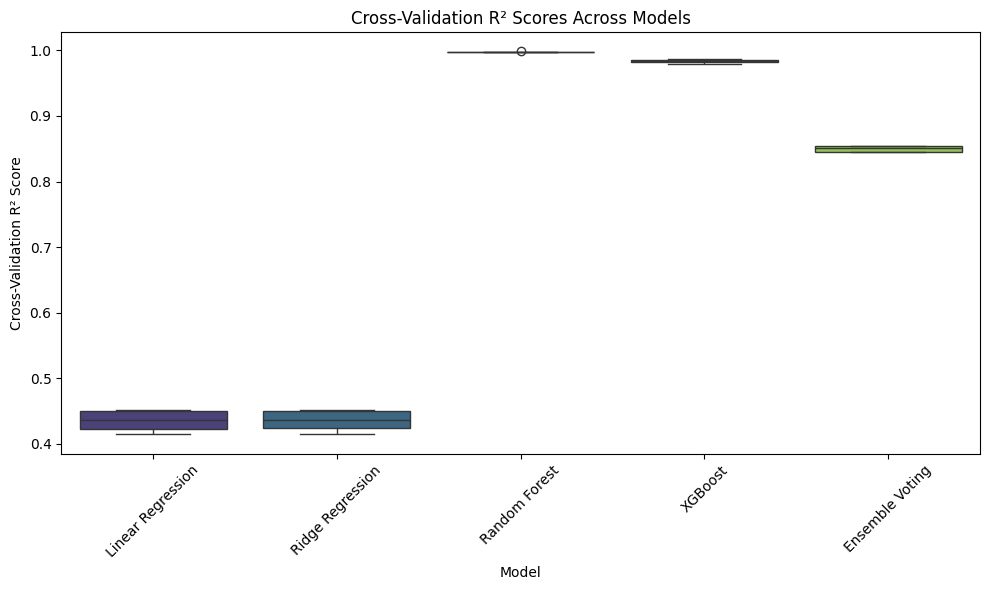

In [81]:
from sklearn.model_selection import cross_val_score
import pandas as pd

def plot_cv_scores(model_dict, X_train, y_train, cv=5):
    """Plot box plot of cross-validation R² scores"""
    cv_scores_dict = {}
    for name, model in model_dict.items():
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
        cv_scores_dict[name] = scores
        print(f"{name} CV R²: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")

    # Convert to DataFrame for plotting
    cv_scores_df = pd.DataFrame(cv_scores_dict)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=cv_scores_df, palette='viridis')
    plt.xlabel('Model')
    plt.ylabel('Cross-Validation R² Score')
    plt.title('Cross-Validation R² Scores Across Models')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('cv_scores_boxplot.png')
    plt.show()

# Plot CV scores
print("\nCross-Validation Scores")
plot_cv_scores(model_dict, X_train, y_train, cv=5)


Prediction Error Distribution for Linear Regression


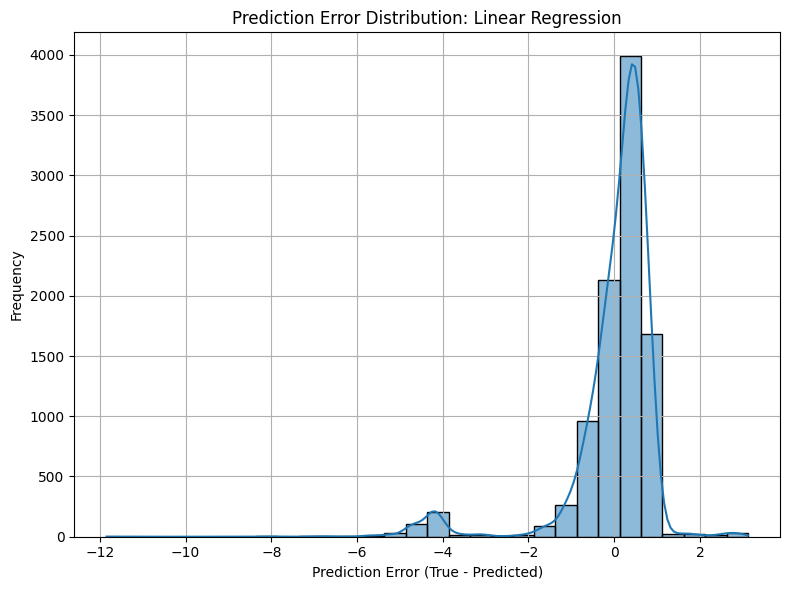


Prediction Error Distribution for Ridge Regression


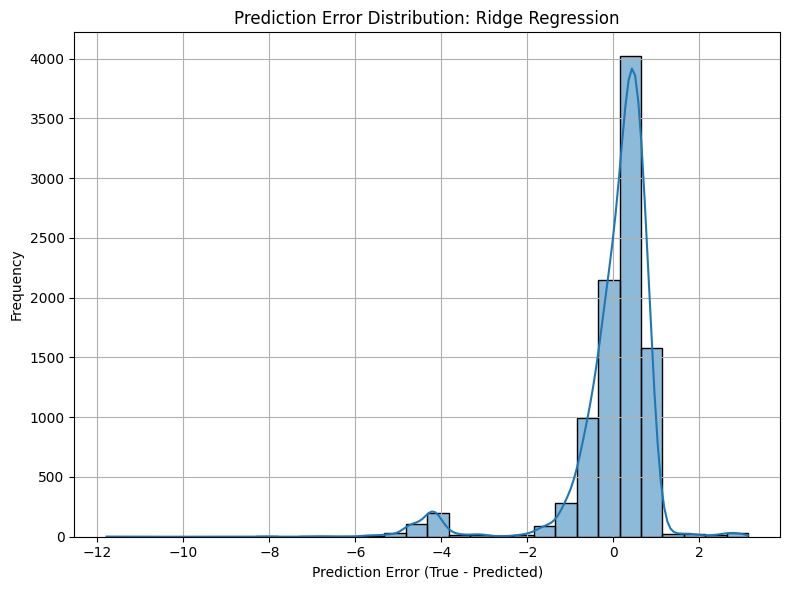


Prediction Error Distribution for Random Forest


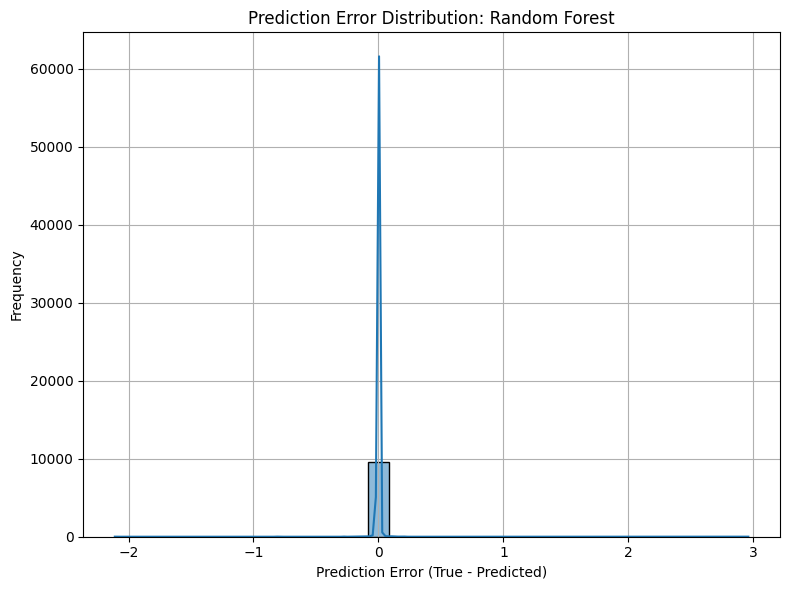


Prediction Error Distribution for XGBoost


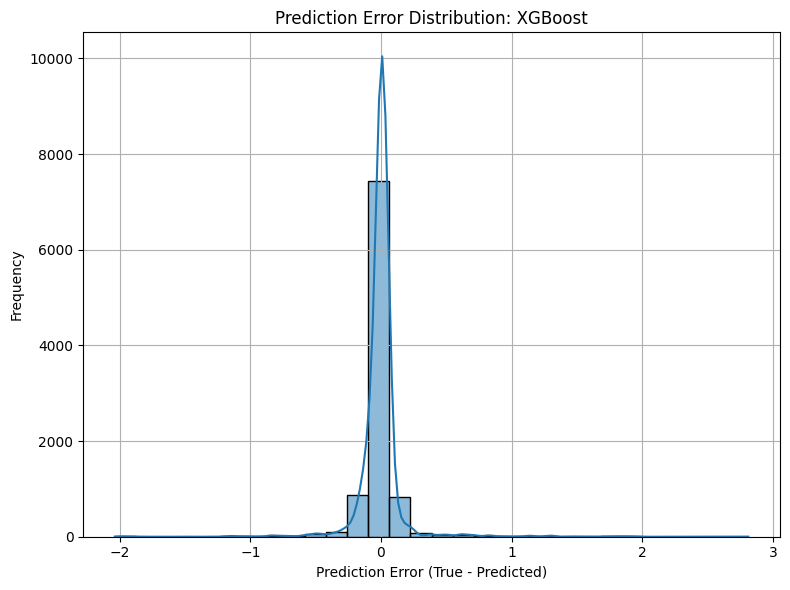


Prediction Error Distribution for Ensemble Voting


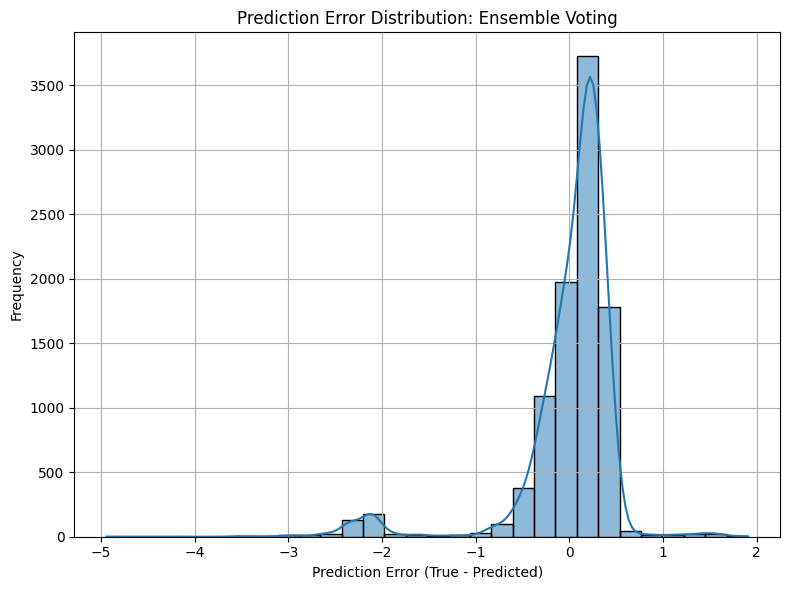

In [83]:
def plot_error_distribution(model, name, X_test_4_features, X_test_5_features, y_test):
    """Plot histogram of prediction errors"""
    # Use X_test_4_features for Linear and Ridge, X_test_5_features for others
    X_test_to_use = X_test_4_features if name in ['Linear Regression', 'Ridge Regression'] else X_test_5_features

    y_pred = model.predict(X_test_to_use)
    errors = y_test - y_pred

    plt.figure(figsize=(8, 6))
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error (True - Predicted)')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Error Distribution: {name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'error_distribution_{name.lower().replace(" ", "_")}.png')
    plt.show()

# Assuming you have X_test_pca with 4 features and X_test with 5 features
for name, model in model_dict.items():
    print(f"\nPrediction Error Distribution for {name}")
    plot_error_distribution(model, name, X_test_pca, X_test, y_test) # Pass both X_test versions

In [93]:
from google.colab import files
uploaded = files.upload()

Saving target_encoder.joblib to target_encoder.joblib


In [89]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.9 MB/s eta 0:00:00


In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import joblib
import pickle
import category_encoders as ce
import os

def get_user_input_and_predict(rf_model, qt, selected_features, target_encoder, training_stats):
    """Prompt user for input and predict selling_proposition using the trained Random Forest model and target encoder"""
    print("\nEnter the details for prediction (follow the prompts below):")
    try:
        product_name = input("Product Name (e.g., Blue T-Shirt): ")
        price = float(input("Price (e.g., 29.99): "))
        discount = float(input("Discount (e.g., 5.00): "))
        color_count = int(input("Color Count (e.g., 3): "))
        rank_sub_input = input("Rank-Sub (e.g., 10 or Kids Fashion Craft Kits, non-numeric values will use default median): ")
        # Convert rank-sub to numeric, mimicking engineer_features
        try:
            rank_sub = float(pd.to_numeric(rank_sub_input, errors='coerce'))
            if pd.isna(rank_sub):
                raise ValueError("Non-numeric input")
        except (ValueError, TypeError):
            print(f"Non-numeric Rank-Sub '{rank_sub_input}' provided. Using default median value: {training_stats.get('rank-sub_median', 0)}")
            rank_sub = training_stats.get('rank-sub_median', 0)
        category = input("Category (e.g., Clothing): ")
    except ValueError as e:
        print(f"Invalid input: {e}. Please ensure:")
        print("- Price, Discount, and Rank-Sub are numbers (e.g., 29.99, 5.00, 10).")
        print("- Color Count is an integer (e.g., 3).")
        print("- Product Name and Category are text strings.")
        return None

    # Create a DataFrame from user input
    input_data = pd.DataFrame({
        'product_name': [product_name],
        'price': [price],
        'discount': [discount],
        'color-count': [color_count],
        'rank-sub': [rank_sub],
        'category': [category],  # Use lowercase 'category'
        'selling_proposition': [0]  # Placeholder for target encoding
    })

    # Step 1: Apply target encoding to category
    # Encode category using target encoder
    category_df = pd.DataFrame({'category': [category]})  # Use lowercase 'category'
    try:
        category_encoded_val = target_encoder.transform(category_df)['category'].values[0]
    except Exception as e:
        print(f"Error encoding category: {e}. Using default category encoding.")
        category_encoded_val = training_stats.get('category_encoded_median', 0)

    # Add the encoded column
    input_data['category_encoded'] = category_encoded_val

    # Step 2: Preprocess data (handle missing values, winsorize outliers)
    # Handle missing values
    for col in input_data.columns:
        if input_data[col].dtype in ['int64', 'float64']:
            input_data[col] = input_data[col].fillna(training_stats.get(f'{col}_median', input_data[col].median()))
        else:
            input_data[col] = input_data[col].fillna(training_stats.get(f'{col}_mode', input_data[col].mode()[0] if not input_data[col].mode().empty else "Unknown"))

    # Winsorize outliers for numeric columns
    numeric_cols = ['price', 'discount', 'rank-sub']
    for col in numeric_cols:
        if col in input_data.columns and input_data[col].dtype in ['int64', 'float64']:
            lower_bound = training_stats.get(f'{col}_lower_bound', input_data[col].quantile(0.005))
            upper_bound = training_stats.get(f'{col}_upper_bound', input_data[col].quantile(0.995))
            input_data[col] = input_data[col].clip(lower=lower_bound, upper=upper_bound)

    # Step 3: Feature engineering (same as engineer_features)
    # Text-based features
    input_data['name_length'] = input_data['product_name'].str.len()
    input_data['word_count'] = input_data['product_name'].str.split().str.len()

    # Numeric transformations and ratios
    input_data['discount_ratio'] = input_data['discount'] / (input_data['price'] + 0.001)
    input_data['discount_ratio'] = input_data['discount_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
    input_data['discount_percentage'] = (input_data['discount'] / (input_data['price'] + 0.001)) * 100
    input_data['discount_percentage'] = input_data['discount_percentage'].clip(0, 100)
    input_data['has_discount'] = (input_data['discount'] > 0).astype(int)

    # Price relative to category
    category_encoded = input_data['category_encoded'].iloc[0]
    price_mean = training_stats.get(f'price_mean_category_{category_encoded}', input_data['price'].mean())
    input_data['price_category_ratio'] = input_data['price'] / (price_mean + 0.001)
    input_data['price_category_ratio'] = input_data['price_category_ratio'].replace([np.inf, -np.inf], 1).fillna(1)
    input_data['price_category_pct'] = 5  # Default middle percentile
    input_data['price_zscore'] = (input_data['price'] - price_mean) / (training_stats.get(f'price_std_category_{category_encoded}', input_data['price'].std()) + 0.001)

    # Rank-based features
    input_data['rank_freq'] = training_stats.get(f'rank_freq_{int(input_data["rank-sub"].iloc[0])}', 0.1)
    input_data['rank_target_enc'] = training_stats.get(f'rank_target_enc_{int(input_data["rank-sub"].iloc[0])}',
    training_stats.get('selling_proposition_mean', 0))
    input_data['log_rank'] = np.log1p(input_data['rank-sub'])
    input_data['log_rank'] = input_data['log_rank'].fillna(0)
    input_data['rank_inverse'] = 1 / (input_data['rank-sub'] + 1)
    input_data['rank_inverse'] = input_data['rank_inverse'].replace([np.inf, -np.inf], 0).fillna(0)
    input_data['rank_norm'] = input_data['rank-sub'] / (training_stats.get(f'rank_max_category_{category_encoded}', input_data['rank-sub'].max()) + 1)
    input_data['rank_norm'] = input_data['rank_norm'].fillna(0.5)
    input_data['rank_percentile'] = 5  # Default middle percentile

    # Color count interactions
    color_mean = training_stats.get(f'color_mean_category_{category_encoded}', input_data['color-count'].mean())
    input_data['price_per_color'] = input_data['price'] / (input_data['color-count'] + 0.001)
    input_data['price_per_color'] = input_data['price_per_color'].replace([np.inf, -np.inf], input_data['price'].mean()).fillna(input_data['price'].mean())
    input_data['color_category_ratio'] = input_data['color-count'] / (color_mean + 0.001)
    input_data['color_category_ratio'] = input_data['color_category_ratio'].replace([np.inf, -np.inf], 1).fillna(1)
    input_data['category_color_interaction'] = input_data['category_encoded'] * input_data['color-count']

    # Polynomial features
    input_data['price_squared'] = input_data['price'] ** 2
    input_data['discount_squared'] = input_data['discount'] ** 2
    input_data['price_discount_interaction'] = input_data['price'] * input_data['discount']

    # Selling proposition features (placeholders)
    input_data['selling_prop_per_dollar'] = 0  # Not used in prediction
    input_data['selling_prop_category_ratio'] = 1  # Default ratio

    # Step 4: Select features used by the model
    # Ensure all selected_features are present in input_data, fill missing with defaults
    for feature in selected_features:
        if feature not in input_data.columns:
            print(f"Warning: Feature '{feature}' not in input_data. Filling with default value 0.")
            input_data[feature] = 0
    X_input = input_data[selected_features]
    X_input = X_input.fillna(0)  # Fill any remaining NaNs

    # Step 5: Predict using the Random Forest model (no scaling required)
    y_pred_quantile = rf_model.predict(X_input)

    # Step 6: Inverse transform the predicted quantile to original scale
    y_pred = qt.inverse_transform(y_pred_quantile.reshape(-1, 1)).flatten()

    print(f"\nPredicted Selling Proposition: {y_pred[0]:.2f}")
    return y_pred[0]

# Example usage
# Load required objects with error handling
try:
    rf_model = joblib.load('rf_model.joblib')
    print("Random Forest model loaded successfully!")
except FileNotFoundError:
    print("Error: rf_model.joblib not found. Please ensure the file is uploaded to the working directory.")
    rf_model = None
except Exception as e:
    print(f"Error loading rf_model.joblib: {e}")
    rf_model = None

try:
    qt = joblib.load('quantile_transformer.joblib')
    print("Quantile transformer loaded successfully!")
except FileNotFoundError:
    print("Error: quantile_transformer.joblib not found. Please ensure the file is uploaded to the working directory.")
    qt = None
except Exception as e:
    print(f"Error loading quantile_transformer.joblib: {e}")
    qt = None

try:
    target_encoder = joblib.load('target_encoder.joblib')
    print("Target encoder loaded successfully!")
except FileNotFoundError:
    print("Error: target_encoder.joblib not found. Please ensure the file is uploaded to the working directory.")
    target_encoder = None
except Exception as e:
    print(f"Error loading target_encoder.joblib: {e}")
    print("The target_encoder.joblib file may be corrupted or invalid. Try recreating it with the following code:")
    print("""
import joblib
import category_encoders as ce
import pandas as pd

df = pd.read_csv('data_cleaning (3).csv')  # Adjust path
df_train = df[df['selling_proposition'].notna()].copy()
encoder = ce.TargetEncoder(cols=['category'])  # Use lowercase 'category'
df_train['category_encoded'] = encoder.fit_transform(df_train['category'], df_train['selling_proposition'])
joblib.dump(encoder, 'target_encoder.joblib')
print("Target encoder saved as target_encoder.joblib")
    """)
    target_encoder = None

try:
    selected_features = joblib.load('selected_features.joblib')
    print("Selected features loaded successfully!")
except FileNotFoundError:
    print("Error: selected_features.joblib not found. Please ensure the file is uploaded to the working directory.")
    selected_features = None
except Exception as e:
    print(f"Error loading selected_features.joblib: {e}")
    selected_features = None

try:
    training_stats = joblib.load('training_stats.joblib')
    print("Training statistics loaded successfully!")
except FileNotFoundError:
    print("Warning: training_stats.joblib not found. Attempting to compute training statistics from DataFrame.")
    try:
        if 'df' not in globals():
            raise NameError("DataFrame 'df' is not defined.")
        required_columns = ['price', 'discount', 'rank-sub', 'product_name', 'category', 'category_encoded', 'color-count', 'selling_proposition']
        if not all(col in df.columns for col in required_columns):
            raise ValueError(f"DataFrame 'df' is missing required columns: {required_columns}")
        # Compute rank-sub statistics
        category_freq = df['rank-sub'].value_counts(normalize=True)
        target_mean = df['selling_proposition'].mean()
        smoothing_factor = 50
        category_target_mean = df.groupby('rank-sub')['selling_proposition'].mean()
        category_counts = df['rank-sub'].value_counts()
        training_stats = {
            'price_median': df['price'].median(),
            'discount_median': df['discount'].median(),
            'rank-sub_median': df['rank-sub'].median(),
            'product_name_mode': df['product_name'].mode()[0],
            'category_mode': df['category'].mode()[0] if not df['category'].mode().empty else "Unknown",
            'category_encoded_median': df['category_encoded'].median(),
            'price_lower_bound': df['price'].quantile(0.005),
            'price_upper_bound': df['price'].quantile(0.995),
            'discount_lower_bound': df['discount'].quantile(0.005),
            'discount_upper_bound': df['discount'].quantile(0.995),
            'rank-sub_lower_bound': df['rank-sub'].quantile(0.005),
            'rank-sub_upper_bound': df['rank-sub'].quantile(0.995),
            **{f'price_mean_category_{k}': v for k, v in df.groupby('category_encoded')['price'].mean().to_dict().items()},
            **{f'price_std_category_{k}': v for k, v in df.groupby('category_encoded')['price'].std().to_dict().items()},
            **{f'color_mean_category_{k}': v for k, v in df.groupby('category_encoded')['color-count'].mean().to_dict().items()},
            **{f'rank_max_category_{k}': v for k, v in df.groupby('category_encoded')['rank-sub'].max().to_dict().items()},
            **{f'rank_freq_{k}': v for k, v in category_freq.to_dict().items()},
            **{f'rank_target_enc_{k}': (category_target_mean.get(k, target_mean) * category_counts.get(k, 0) + target_mean * smoothing_factor) /
               (category_counts.get(k, 0) + smoothing_factor) for k in category_counts.index}
        }
        print("Training statistics computed successfully from DataFrame.")
    except NameError:
        print("Error: DataFrame 'df' is not defined. Please load the DataFrame or upload training_stats.joblib.")
        print("To load the DataFrame, run:")
        print("import pandas as pd")
        print("df = pd.read_csv('data_cleaning (3).csv')  # Adjust path")
        training_stats = None
    except ValueError as ve:
        print(f"Error: {ve}")
        training_stats = None
    except Exception as e:
        print(f"Error computing training statistics: {e}")
        training_stats = None
except Exception as e:
    print(f"Error loading training_stats.joblib: {e}")
    training_stats = None

# Check if all required objects are loaded
if all([rf_model, qt, target_encoder, selected_features, training_stats]):
    predicted_value = get_user_input_and_predict(
        rf_model, qt, selected_features, target_encoder, training_stats
    )
else:
    print("Cannot proceed with prediction due to missing required objects.")
    if not target_encoder:
        print("Missing target_encoder. Please recreate and upload target_encoder.joblib as shown above.")
    if not training_stats:
        print("Missing training_stats. Please upload training_stats.joblib or load the DataFrame 'df' to compute it.")

Random Forest model loaded successfully!
Quantile transformer loaded successfully!
Target encoder loaded successfully!
Selected features loaded successfully!
Training statistics computed successfully from DataFrame.

Enter the details for prediction (follow the prompts below):
Product Name (e.g., Blue T-Shirt): 'Cooking Master' Digital Food Kitchen Scale,22lb Weight Multifunction Scale Measures In Grams And Ounces For Cooking Baking Prep,1g/0.1oz Precise Graduation,Stainless Steel And Tempered Glass
Price (e.g., 29.99): 26.99
Discount (e.g., 5.00): 0.4
Color Count (e.g., 3): 1
Rank-Sub (e.g., 10 or Kids Fashion Craft Kits, non-numeric values will use default median): Appliances
Non-numeric Rank-Sub 'Appliances' provided. Using default median value: 8.0
Category (e.g., Clothing): Appliances


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- category_encoded
